In [1]:
import pandas as pd
import numpy as np
import os

import geopandas as gpd
#from geopandas.tools import sjoin
#from shapely.geometry import Point

import matplotlib.pyplot as plt
#to horizontally align the plot axes and the legend axes and change the width
from mpl_toolkits.axes_grid1 import make_axes_locatable 


%matplotlib inline

The aim of this notebook is to pull in several types of data for the city of Chicago. I'll look at demographic data, crime data, transportation, business data, and rental listings in order to determine some insights about the different areas to live in the city.

Ultimately the goal is to build an app that will take these different data into consideration to help a user figure out what areas of the city they would like to live in.

However, I'll take the opportunity to play around with the data and practice different data/ml techniques along the way as I explore the data.

Data Sources

Biz Licenses
https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses-Current-Active/uupf-x98q
This page will give some context about the business licenses dataset. May need some NLP to get better categorizations
about what kind of businesses these are

Crime
https://data.cityofchicago.org/Public-Safety/Crimes-2020/qzdf-xmn8

L Stops
https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme

Boundaries - Community Areas and Zip
https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6
https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw

National Historical GIS (NHGIS)
https://www.nhgis.org
Block Group and tract level info for: Race, edu attainment, median hh income, and employment status

Rental listings were scraped from realtor.com using a script I wrote.

In [399]:
#os.getcwd()

In [3]:
data_path = "~/Documents/Data_Science_Projects/Chicago_Tool/Data/"

cta_df = pd.read_csv(data_path + "CTA_-_System_Information_-_List_of__L__Stops.csv")
crime_df = pd.read_csv(data_path + "Crimes_-_2020.csv")
census_df = pd.read_csv(data_path + "nhgis0012_csv/nhgis0012_ds254_20215_blck_grp.csv")
biz_df = pd.read_csv(data_path + "Business_Licenses_-_Current_Active.csv")
rental_df = pd.read_csv(data_path + "Chicago_Rentals_Sample_Oct1923.csv")

/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
""" Census dictionary for column names 
"""
census_dic = {"AON5E001":"pop_total", "AON5E002":"pop_white", "AON5E003":"pop_black", "AON5E005":"pop_asian", "AON5E007":"pop_other",
 "AON5E008":"pop_mixed",
              "AOOCE001":"hisp_total", "AOOCE012": "is_hispanic",
 "AOP8E001": "edu_total", "AOP8E017":"edu_hsgrad", "AOP8E022":"edu_bachelor",
 "AOQIE001": "income_medhh",
 "AOSJE001": "emp_total", "AOSJE002":"emp_inLF", "AOSJE004":"emp_employed", "AOSJE005":"emp_unemployed","AOSJE006":"emp_army"
}

In [5]:
# includes masters, professional degree and phD
census_df["edu_>bachelor"] = census_df["AOP8E023"] + census_df["AOP8E024"] + census_df["AOP8E025"]

# includes native americans and pacific islanders
census_df["pop_native"] = census_df["AON5E004"] + census_df["AON5E006"]

In [6]:
census_df.rename(columns=census_dic, inplace = True)

In [7]:
#census_df.iloc[:,20:30]

census_df=census_df[["GISJOIN", "STUSAB", "COUNTY","TRACTA", "BLKGRPA", "GEO_ID",
           "pop_total", "pop_white", "pop_black","hisp_total", "is_hispanic", "pop_asian", "pop_native", "pop_other", "pop_mixed",
           "edu_total", "edu_hsgrad", "edu_bachelor", "edu_>bachelor",
           "income_medhh",
           "emp_total", "emp_inLF", "emp_employed", "emp_unemployed", "emp_army"
          ]]

In [8]:
census_df = census_df[census_df["COUNTY"] == "Cook County"]
len(census_df)

4002

In [9]:
# to sync formatting with blkGrp sf, TRACTA & BLKGPA need to be strings and TRACTA needs 6 characters. Add 0 in front

census_df["TRACTA"] = census_df["TRACTA"].astype(str)
census_df["BLKGRPA"] = census_df["BLKGRPA"].astype(str)

trct_lst=[]
for i in census_df["TRACTA"]:
    if len(i) < 6:
        correction = (6-len(i)) * "0"
        new_tract = correction + i
    else:
        new_tract = i
    trct_lst.append(new_tract)
    
census_df["TRACTA"] =trct_lst

In [10]:
census_df.head()

GISJOIN STUSAB       COUNTY  TRACTA BLKGRPA  \
494  G17003100101001     IL  Cook County  010100       1   
495  G17003100101002     IL  Cook County  010100       2   
496  G17003100101003     IL  Cook County  010100       3   
497  G17003100102011     IL  Cook County  010201       1   
498  G17003100102012     IL  Cook County  010201       2   

                    GEO_ID  pop_total  pop_white  pop_black  hisp_total  ...  \
494  1500000US170310101001        434        228         57         434  ...   
495  1500000US170310101002       2116        674       1228        2116  ...   
496  1500000US170310101003       1984       1103        466        1984  ...   
497  1500000US170310102011       2175        681        807        2175  ...   
498  1500000US170310102012       2057        561        856        2057  ...   

     edu_total  edu_hsgrad  edu_bachelor  edu_>bachelor  income_medhh  \
494        399         103            52            129       76797.0   
495       1232         214           385            107       22179.0   
496       1654         121           561            444       67371.0   
497       1445         311           208            286       58068.0   
498       1154         212           291            150       41936.0   

     emp_total  emp_inLF  emp_employed  emp_unemployed  emp_army  
494        434       350           334              16         0  
495       1552       976           891              85         0  
496       1924      1504          1418              86         0  
497       1714      1223          1112             111         0  
498       1406       961           945              16         0  

[5 rows x 25 columns]

In [11]:
# count missing values per column
missing_col = [census_df[i].isna().sum() for i in census_df.columns]
#census_df.isna().sum( axis=0)

missing_perc = [i/len(census_df) for i in missing_col]
missing_perc_df = pd.DataFrame({"col_name": census_df.columns, "prop_missing": missing_perc}).sort_values(by=['prop_missing'], ascending=False)

missing_perc_df

col_name  prop_missing
19    income_medhh      0.081459
0          GISJOIN      0.000000
13       pop_other      0.000000
23  emp_unemployed      0.000000
22    emp_employed      0.000000
21        emp_inLF      0.000000
20       emp_total      0.000000
18   edu_>bachelor      0.000000
17    edu_bachelor      0.000000
16      edu_hsgrad      0.000000
15       edu_total      0.000000
14       pop_mixed      0.000000
12      pop_native      0.000000
1           STUSAB      0.000000
11       pop_asian      0.000000
10     is_hispanic      0.000000
9       hisp_total      0.000000
8        pop_black      0.000000
7        pop_white      0.000000
6        pop_total      0.000000
5           GEO_ID      0.000000
4          BLKGRPA      0.000000
3           TRACTA      0.000000
2           COUNTY      0.000000
24        emp_army      0.000000

In [12]:
# About 8% of rows are missing income
# are there any rows with 0 for income? No
print(census_df[census_df.income_medhh == 0])

Empty DataFrame
Columns: [GISJOIN, STUSAB, COUNTY, TRACTA, BLKGRPA, GEO_ID, pop_total, pop_white, pop_black, hisp_total, is_hispanic, pop_asian, pop_native, pop_other, pop_mixed, edu_total, edu_hsgrad, edu_bachelor, edu_>bachelor, income_medhh, emp_total, emp_inLF, emp_employed, emp_unemployed, emp_army]
Index: []

[0 rows x 25 columns]


In [13]:
# Since there are no incomes of 0 in the data, replace the na's with 0 for now
census_df.loc[census_df["income_medhh"].isna(), "income_medhh"] = 0


In [14]:
census_df.columns

Index(['GISJOIN', 'STUSAB', 'COUNTY', 'TRACTA', 'BLKGRPA', 'GEO_ID',
       'pop_total', 'pop_white', 'pop_black', 'hisp_total', 'is_hispanic',
       'pop_asian', 'pop_native', 'pop_other', 'pop_mixed', 'edu_total',
       'edu_hsgrad', 'edu_bachelor', 'edu_>bachelor', 'income_medhh',
       'emp_total', 'emp_inLF', 'emp_employed', 'emp_unemployed', 'emp_army'],
      dtype='object')

# Explore the Data

We have features dealing with population race, education level, income, and employment status at the census block group level (a census block is the smallest geographic census unit)

Are there any:
* interesting relationships
* outliers
* feature transformations that could be more insightful

In [15]:
census_df.describe().transpose()

count          mean           std  min       25%      50%  \
pop_total       4002.0   1315.691654    614.407331  0.0    889.00   1207.0   
pop_white       4002.0    684.665667    535.564711  0.0    254.00    630.0   
pop_black       4002.0    302.658671    456.952559  0.0      2.25     72.5   
hisp_total      4002.0   1315.691654    614.407331  0.0    889.00   1207.0   
is_hispanic     4002.0    336.568966    439.793750  0.0     38.00    155.0   
pop_asian       4002.0     99.158171    189.165255  0.0      0.00     23.0   
pop_native      4002.0      6.230635     24.317590  0.0      0.00      0.0   
pop_other       4002.0    130.820340    226.847148  0.0      0.00     30.0   
pop_mixed       4002.0     92.158171    127.249450  0.0     10.00     49.0   
edu_total       4002.0    913.641429    441.702300  0.0    611.00    833.0   
edu_hsgrad      4002.0    178.945027    136.845670  0.0     78.00    156.0   
edu_bachelor    4002.0    217.381309    194.315487  0.0     79.00    169.0   
edu_>bachelor   4002.0    154.915292    180.673696  0.0     36.00     98.0   
income_medhh    4002.0  75150.821339  47754.684987  0.0  43911.75  69205.0   
emp_total       4002.0   1060.534483    514.695040  0.0    709.25    962.0   
emp_inLF        4002.0    701.976512    372.642102  0.0    447.00    630.0   
emp_employed    4002.0    650.616442    361.601578  0.0    402.00    585.0   
emp_unemployed  4002.0     50.967016     55.258212  0.0     13.00     34.0   
emp_army        4002.0      0.393053      3.499089  0.0      0.00      0.0   

                     75%       max  
pop_total        1645.75   10528.0  
pop_white        1001.00    3445.0  
pop_black         453.00    6944.0  
hisp_total       1645.75   10528.0  
is_hispanic       453.75    3353.0  
pop_asian         111.00    1797.0  
pop_native          0.00     476.0  
pop_other         153.00    2480.0  
pop_mixed         122.00    1344.0  
edu_total        1133.00    7642.0  
edu_hsgrad        253.00    2711.0  
edu_bachelor      297.00    1869.0  
edu_>bachelor     213.75    2107.0  
income_medhh    99061.50  250001.0  
emp_total        1325.00   10257.0  
emp_inLF          890.00    4300.0  
emp_employed      829.00    4044.0  
emp_unemployed     72.00     538.0  
emp_army            0.00      70.0

In [16]:
# corr plot
corr = census_df.corr()
corr.style.background_gradient(cmap='coolwarm')

From the corr plot above we can see correlations. We can also confirm if the census total variables for each specific piece of data is in line with population totals. 

We see this is true for hispanic totals, which means if we go to convert to percents, is_hispanic will be on par with other race vars. 

However, the same does not hold true for education attainment totals and employed totals, which means the data may have been collected differently here.

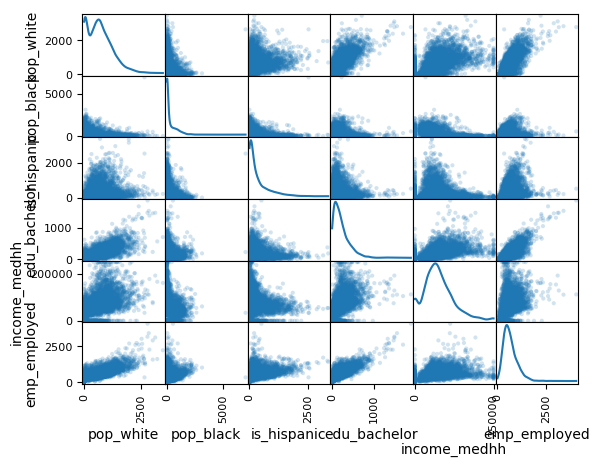

In [17]:
high_level_vars = ["pop_white", "pop_black","is_hispanic", "edu_bachelor", "income_medhh","emp_employed"]
pd.plotting.scatter_matrix(census_df[high_level_vars], diagonal = 'kde', alpha = 0.2)
#plt.rcParams['figure.figsize'] = [20, 12]
plt.show()

Some interesting relationships. Higher absolute numbers of white people have clearly positive relationships with education attainment, income, and employment. This is not true for black populations. But we're dealing in absolute numbers. It probably makes more sense to see percent makeup of block groups rather than absolute counts to take out size component and have clearer view of diversity/variation.

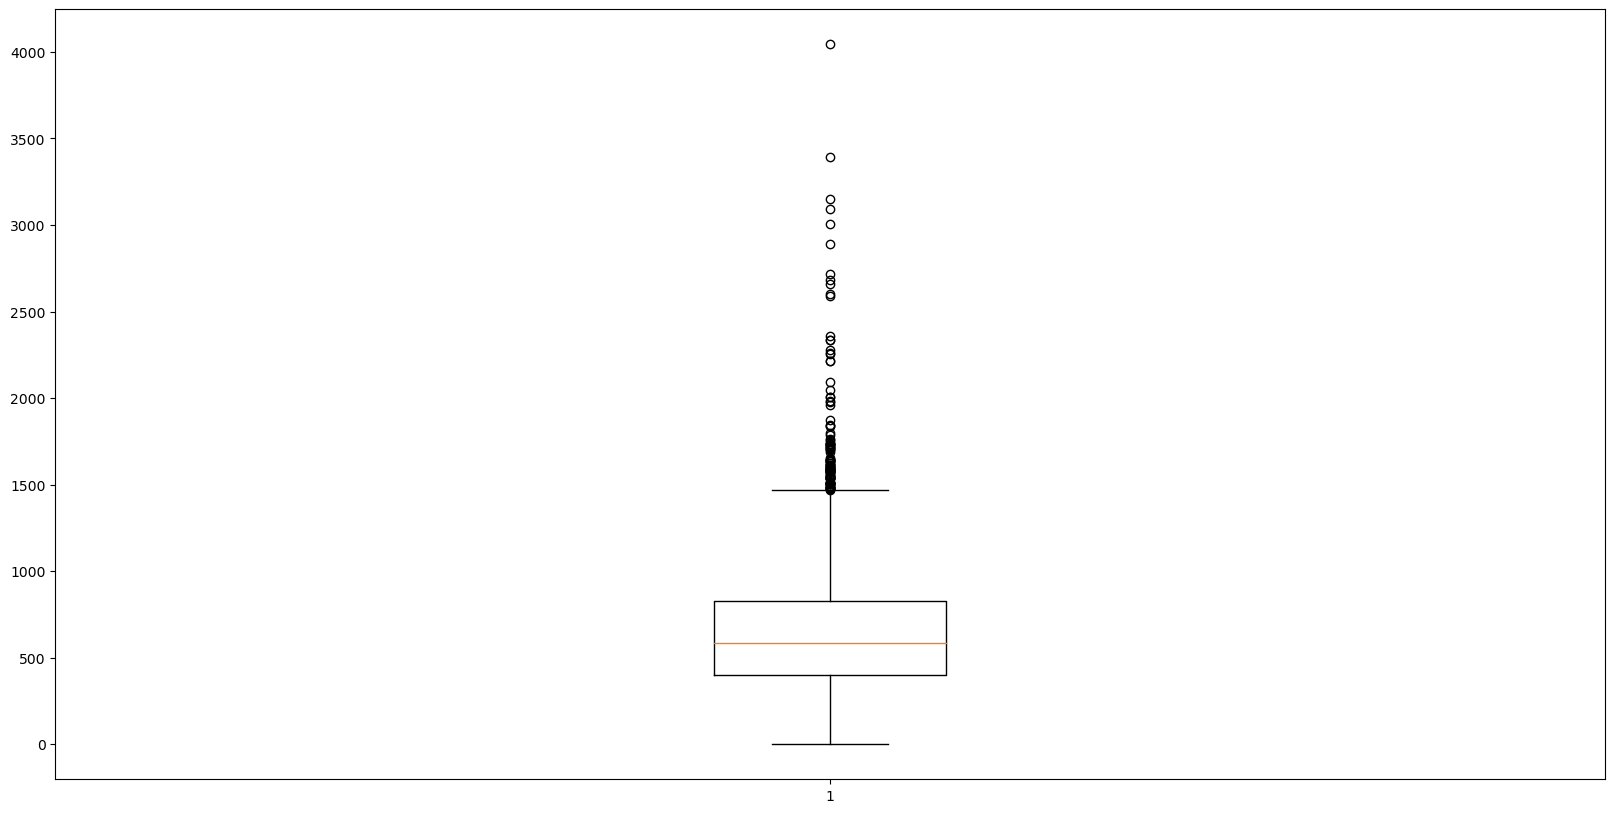

In [18]:
# could check out some boxplots to look for outliers, but this tells us more about the population size of the block group
# than any real info. Need the percents.
fig = plt.figure(figsize =(20, 10))

#ax = fig.add_axes([0, 0, 1, 1])

#plt.boxplot(census_df["income_medhh"])
plt.boxplot(census_df["emp_employed"])
# Creating plot
#bp = ax.boxplot(census_df)
 
# show plot
plt.show()

Create some new variables that will take away the influence of pop size of the block group

In [19]:
census_df.columns

Index(['GISJOIN', 'STUSAB', 'COUNTY', 'TRACTA', 'BLKGRPA', 'GEO_ID',
       'pop_total', 'pop_white', 'pop_black', 'hisp_total', 'is_hispanic',
       'pop_asian', 'pop_native', 'pop_other', 'pop_mixed', 'edu_total',
       'edu_hsgrad', 'edu_bachelor', 'edu_>bachelor', 'income_medhh',
       'emp_total', 'emp_inLF', 'emp_employed', 'emp_unemployed', 'emp_army'],
      dtype='object')

In [20]:
def to_perc_fun(df, total, group, new_var_name):
    """group is the group column name,
       new_var_name is name of new column after calc"""
    df[new_var_name] = df[group]/df[total]



In [21]:
to_perc_fun(census_df, "pop_total", "pop_white", "perc_white")
to_perc_fun(census_df, "pop_total", "pop_black", "perc_black")
to_perc_fun(census_df, "pop_total", "is_hispanic", "perc_hispanic")
to_perc_fun(census_df, "pop_total", "pop_asian", "perc_asian")
to_perc_fun(census_df, "pop_total", "pop_native", "perc_native")
to_perc_fun(census_df, "pop_total", "pop_other", "perc_other")
to_perc_fun(census_df, "pop_total", "pop_mixed", "perc_mixed")
to_perc_fun(census_df, "edu_total", "edu_hsgrad", "perc_hsgrad")
to_perc_fun(census_df, "edu_total", "edu_bachelor", "perc_bachelor")
to_perc_fun(census_df, "edu_total", "edu_>bachelor", "perc_>bachelor")
to_perc_fun(census_df, "emp_total", "emp_inLF", "perc_inLaborForce")
to_perc_fun(census_df, "emp_total", "emp_employed", "perc_employed")
to_perc_fun(census_df, "emp_total", "emp_unemployed", "perc_unemployed")
to_perc_fun(census_df, "emp_total", "emp_army", "perc_army")



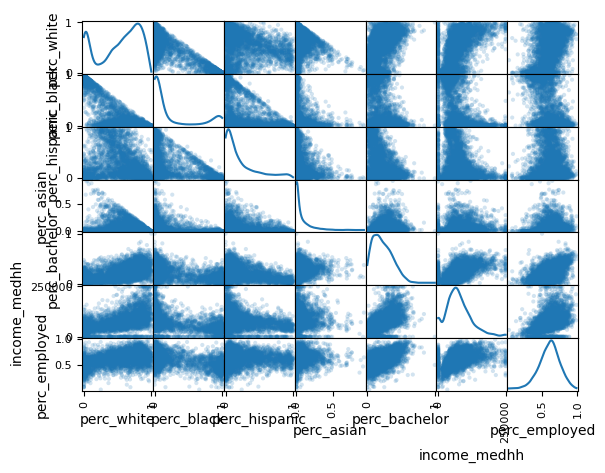

In [22]:
high_level_vars = ["perc_white", "perc_black","perc_hispanic","perc_asian", "perc_bachelor", "income_medhh","perc_employed"]
pd.plotting.scatter_matrix(census_df[high_level_vars], diagonal = 'kde', alpha = 0.2)
#plt.rcParams['figure.figsize'] = [20, 12]
plt.show()

In [23]:
corr = census_df[high_level_vars].corr()
corr.style.background_gradient(cmap='RdYlGn')

<AxesSubplot:>

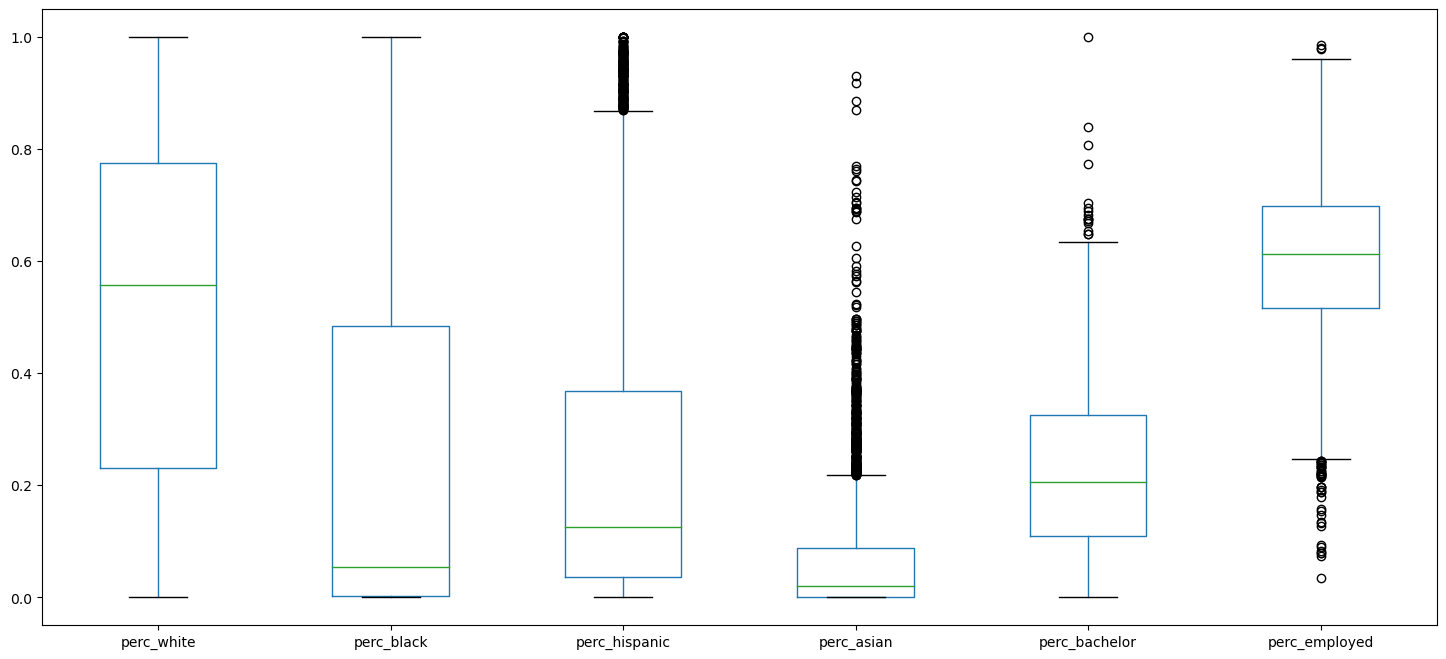

In [24]:
# Looking at the distribution of our demographic percents across block groups
# Note that this is plotting using pandas
# seems like using seaborn would be a good way to go if had long data, 
# ie race was a column, and some numeric value was another column and wanted to see the distro; https://www.geeksforgeeks.org/box-plot-visualization-with-pandas-and-seaborn/
# I think this long form is also necessary for matplotlib...passing essentially a label column and a value column
census_df[["perc_white", "perc_black","perc_hispanic",
           "perc_asian", "perc_bachelor", "perc_employed"]].boxplot(figsize=[18,8], grid= False)




Boxplot above tells us that about half of block groups have a white population <=55%, where about half have a black population <10%.
Also tells that 75% of block groups have an employed rate of ~75% or lower

<AxesSubplot:>

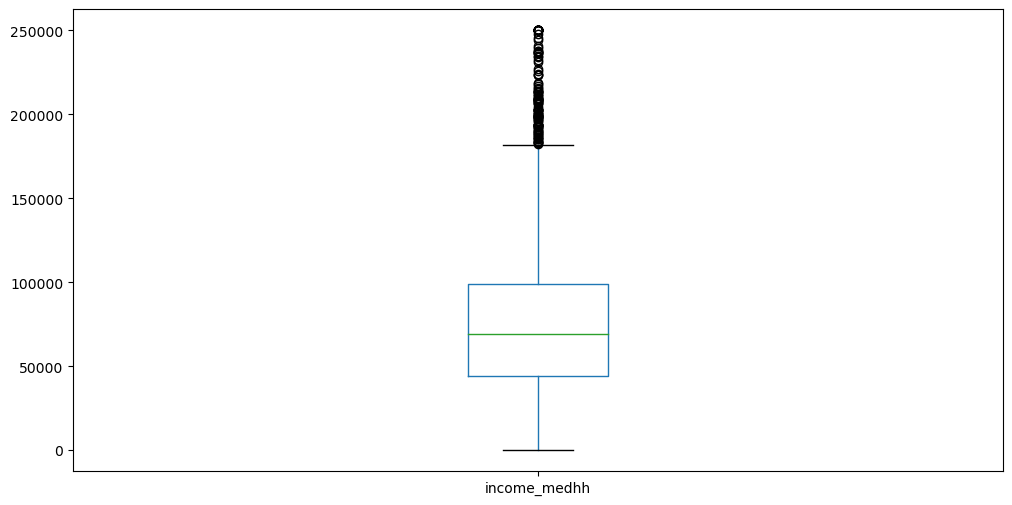

In [25]:
census_df[["income_medhh"]].boxplot(figsize=[12,6], grid=False)
# this is saying that around half of block groups have median hh income at or below about $75K

In [26]:
round(census_df["income_medhh"].mean())

75151

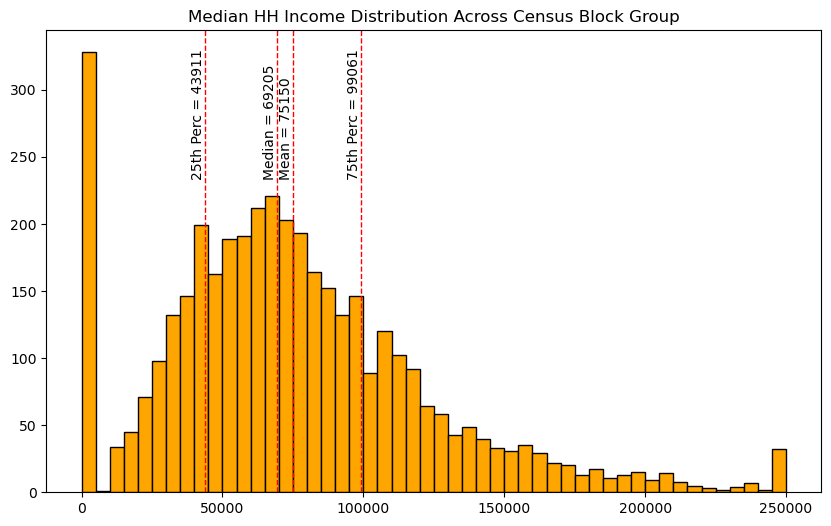

In [27]:
inc_quants = np.quantile(census_df[["income_medhh"]], [0.25,.5,.75,1])

plt.figure(figsize=[10,6])
plt.hist(census_df["income_medhh"], bins = round(census_df["income_medhh"].max()/5000), 
         color="orange", edgecolor='black')

plt.axvline(inc_quants[1], color='r', linestyle='dashed', linewidth=1)
plt.text(inc_quants[1]-5000, 235, 'Median = '+str(int(inc_quants[1]) ), rotation=90)

plt.axvline(inc_quants[0], color='r', linestyle='dashed', linewidth=1)
plt.text(inc_quants[0]-5000, 235, '25th Perc = '+str(int(inc_quants[0]) ), rotation=90)

plt.axvline(census_df["income_medhh"].mean(), color='r', linestyle='dashed', linewidth=1)
plt.text(census_df["income_medhh"].mean()-5000, 235, 'Mean = '+str(int(census_df["income_medhh"].mean()) ), rotation=90)

plt.axvline(inc_quants[2], color='r', linestyle='dashed', linewidth=1)
plt.text(inc_quants[2]-5000, 235, '75th Perc = '+str(int(inc_quants[2]) ), rotation=90)

plt.title("Median HH Income Distribution Across Census Block Group")
plt.show()

In [28]:
inc_quants = np.quantile(census_df[["income_medhh"]], [0,0.25,.5,.75,1])

In [29]:
np.quantile(census_df[census_df["income_medhh"] <=5000]["income_medhh"], [0,0.25,.5,.75,1])
# About 75% of that first bar spike has value $0, so this tells me this is largely missing data

array([   0.,    0.,    0.,    0., 2499.])

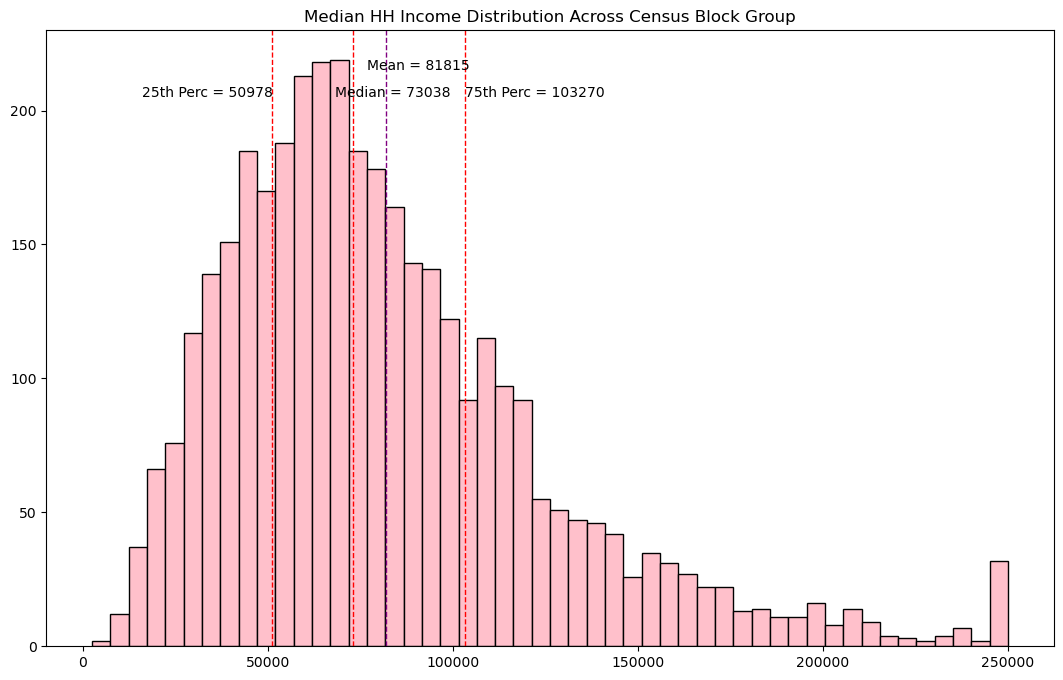

In [30]:
# Removing rows who had income of 0 and replotting

sin0 = census_df[census_df["income_medhh"] != 0]

inc_qnts = np.quantile(sin0[["income_medhh"]], [0.25,.5,.75,1])

plt.figure(figsize=[13,8])
plt.hist(sin0["income_medhh"], bins = round(sin0["income_medhh"].max()/5000), 
         color="pink", edgecolor='black')

plt.axvline(inc_qnts[1], color='r', linestyle='dashed', linewidth=1)
plt.text(inc_qnts[1]-5000, 205, 'Median = '+str(int(inc_qnts[1]) ))

plt.axvline(inc_qnts[0], color='r', linestyle='dashed', linewidth=1)
plt.text(inc_qnts[0]-35000, 205, '25th Perc = '+str(int(inc_qnts[0]) ))

plt.axvline(sin0["income_medhh"].mean(), color='purple', linestyle='dashed', linewidth=1)
plt.text(sin0["income_medhh"].mean()-5000, 215, 'Mean = '+str(int(sin0["income_medhh"].mean()) ))

plt.axvline(inc_qnts[2], color='r', linestyle='dashed', linewidth=1)
plt.text(inc_qnts[2], 205, '75th Perc = '+str(int(inc_qnts[2]) ))

plt.title("Median HH Income Distribution Across Census Block Group")
plt.show()

In [31]:
#paired down vars
census = census_df[['GISJOIN','TRACTA', 'BLKGRPA', 'GEO_ID', 'pop_total', 'emp_total', 
                    'perc_white', 'perc_black', 'perc_hispanic', 'perc_asian','perc_native', 'perc_other', 'perc_mixed',
                    'perc_hsgrad','perc_bachelor', 'perc_>bachelor',
                    'income_medhh',
                    'perc_inLaborForce', 'perc_employed','perc_unemployed'
                   ]]

## Spinning up a Quick Map

In [32]:
# shape file for Chi community areas
cmnty_sf = gpd.read_file("/Users/laurenshores/Documents/Data_Science_Projects/Exploring_Chicago_Neighborhoods/Data/Boundaries_Community_Areas/geo_export_782a78c7-402d-4a93-bb37-c4ab05c3b15b.shp")



/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


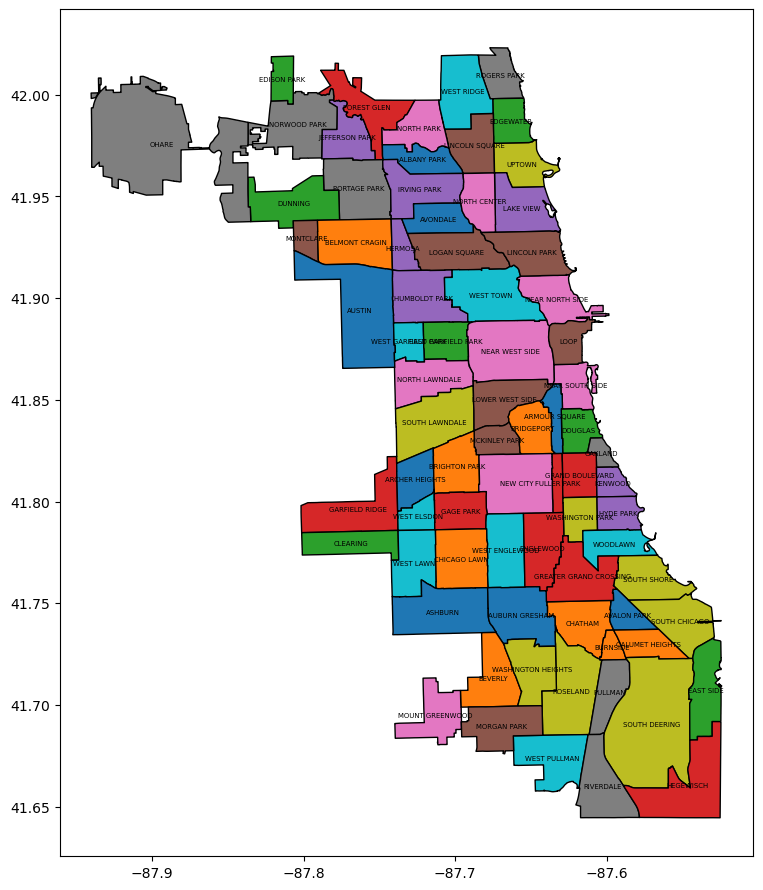

In [33]:
ax = cmnty_sf.plot(column='community', figsize=[18,11], edgecolor='black')

for x, y, label in zip(cmnty_sf.geometry.centroid.x, cmnty_sf.geometry.centroid.y, cmnty_sf['community']):
    ax.text(x, y, label, fontsize=5, ha='center', va='center')

In [34]:
len(cmnty_sf)

77

In [400]:
blkGrp_sf = gpd.read_file("/Users/laurenshores/Documents/Data_Science_Projects/Exploring_Chicago_Neighborhoods/Data/tigerLine_2019_IL_bg/tl_2019_17_bg.shp") 
                          #filter(COUNTYFP == '031', STATEFP == '17')
                          
# cook county is countypf 31
#blkGrp_sf = blkGrp_sf[blkGrp_sf["COUNTYFP"] == "31"].reset_index()

                       

In [36]:
blkGrp_sf = blkGrp_sf[(blkGrp_sf["COUNTYFP"] == "031")]

"""This shapefile contains a bunch of water in lake michigan that makes the plot awkward. 
 filter out the the largest water area """
max_water_area = blkGrp_sf["AWATER"].max()
blkGrp_sf = blkGrp_sf[blkGrp_sf["AWATER"]!= max_water_area]




<AxesSubplot:>

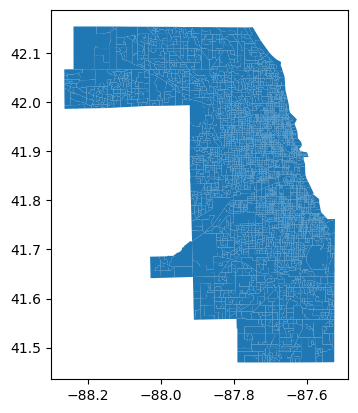

In [37]:
blkGrp_sf.plot()

In [38]:
blkGrp_sf.head(3)


STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
4       17      031  813400        1  170318134001  Block Group 1  G5030   
25      17      031  820502        2  170318205022  Block Group 2  G5030   
26      17      031  672000        3  170316720003  Block Group 3  G5030   

   FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
4         S  415954       0  +41.8626758  -087.7629100   
25        S  455769       0  +41.7518678  -087.8045848   
26        S  184727       0  +41.7620710  -087.6728544   

                                             geometry  
4   POLYGON ((-87.76799 41.86555, -87.76774 41.865...  
25  POLYGON ((-87.80959 41.75345, -87.80942 41.753...  
26  POLYGON ((-87.67475 41.76480, -87.67450 41.764...

In [39]:
# Use a spatial join to add community area info to blockgroup data
"""Here I use within because intersect causes duplicates for block group (probably because some block group boundaries
touch/fall within the boundary of more than one community area). For our purposes, I'd rather have missing community
than have duplicated block groups just to show that it touches to more than one community area

Or, I could do an intersect and just drop duplicates, keeping the first row. This had less missing communities,
without duplicated blockgroups than using the 'within'  method

https://stackoverflow.com/questions/68504942/how-do-geopandas-sjoin-predicate-within-and-intersects-differ

"""

z =gpd.sjoin(blkGrp_sf, cmnty_sf[["community","geometry"]], how="left")
z = z.drop_duplicates(subset= ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'], keep="first")
print(len(z[z["community"].isna()]))
print(z.head(2))

/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  del sys.path[0]


1660
   STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
4       17      031  813400        1  170318134001  Block Group 1  G5030   
25      17      031  820502        2  170318205022  Block Group 2  G5030   

   FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
4         S  415954       0  +41.8626758  -087.7629100   
25        S  455769       0  +41.7518678  -087.8045848   

                                             geometry  index_right community  
4   POLYGON ((-87.76799 41.86555, -87.76774 41.865...         25.0    AUSTIN  
25  POLYGON ((-87.80959 41.75345, -87.80942 41.753...          NaN       NaN  


In [40]:
print(len(z))
print(len(blkGrp_sf))

3992
3992


In [41]:
# Join blkgrp + community data with census data
df = pd.merge(z, census, how="left", left_on=["TRACTCE", "BLKGRPCE"],
         right_on = ["TRACTA", "BLKGRPA"]
        )

df.drop(columns =["index_right"], inplace=True)

In [42]:
print(len(df[df['community'].isna()]))

df['community'] =  df['community'].fillna('Unknown').astype('str')
df['comm_test'] = np.where(df['community'] == "Unknown","Unknown","Other")

1660


<AxesSubplot:>

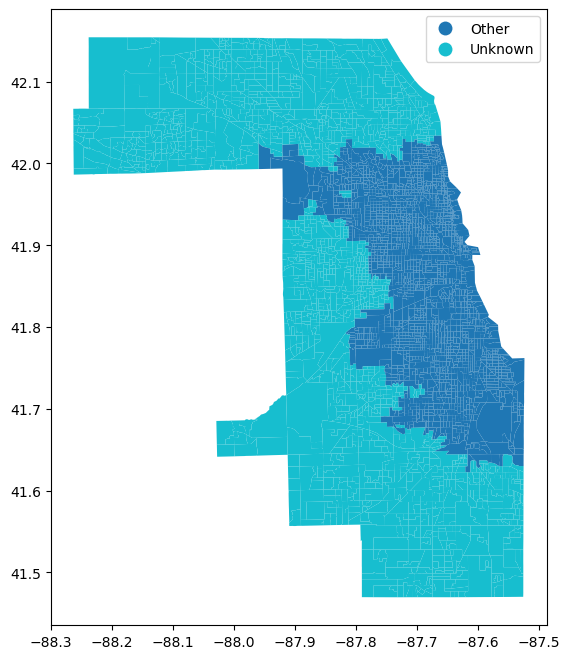

In [43]:
# just taking a look at datasets. blkgrp data is cook county and community data is Chicago. Thus the difference

df.plot(column='comm_test' , figsize=[12,8], legend=True, categorical=True)

#plt.legend(bbox_to_anchor=(1.0, 1.0))
#plt.tight_layout()
# column="income_medhh",  cmap='OrRd', missing_kwds={'color': 'lightgrey'}

In [44]:
print(len(df))
print(len(census))
print(len(blkGrp_sf))

3992
4002
3992


In [45]:
#Checking the projections
df["geometry"].crs 

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [46]:
# Create a feature for population density
df["pop_density"] = df["pop_total"]/ df["ALAND"]

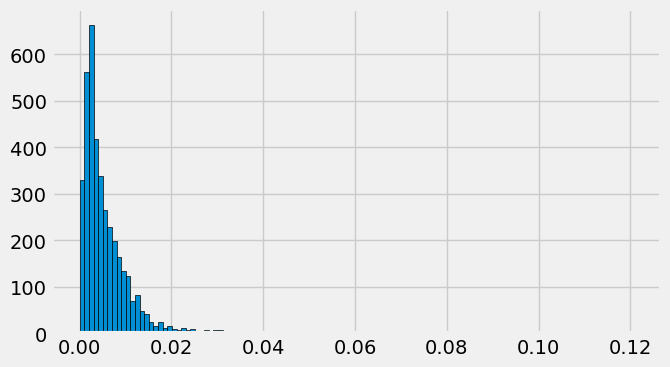

In [402]:
plt.figure(figsize=[7,4])
plt.hist(df["pop_density"], bins= int(df["pop_density"].max()/.001), edgecolor="black")
plt.show()


In [48]:
# Want to break block group income into percentile groups for a cleaner plot.
# using sin0 because this dataset removes block groups with 0 income

#np.quantile(census_df[[""income_medhh""]], [0.25,.5,.75,1])
inc_perc = np.quantile(sin0[["income_medhh"]],[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

df["bg_inc_deciles"] = np.where(df["income_medhh"] < inc_perc[0], "Perc_10th",
        np.where(df["income_medhh"] < inc_perc[1], "Perc_20th",
                np.where(df["income_medhh"] < inc_perc[2], "Perc_30th",
                        np.where(df["income_medhh"] < inc_perc[3], "Perc_40th",
                                np.where(df["income_medhh"] < inc_perc[4], "Perc_50th",
                                        np.where(df["income_medhh"] < inc_perc[5], "Perc_60th",
                                                np.where(df["income_medhh"] < inc_perc[6], "Perc_70th",
                                                        np.where(df["income_medhh"] < inc_perc[7], "Perc_80th",
                                                                np.where(df["income_medhh"] < inc_perc[8], "Perc_90th",
                                                                        "Top"
                                                                        )))))))))

Text(0.5, 1.0, 'Median HH Income by Percentiles')

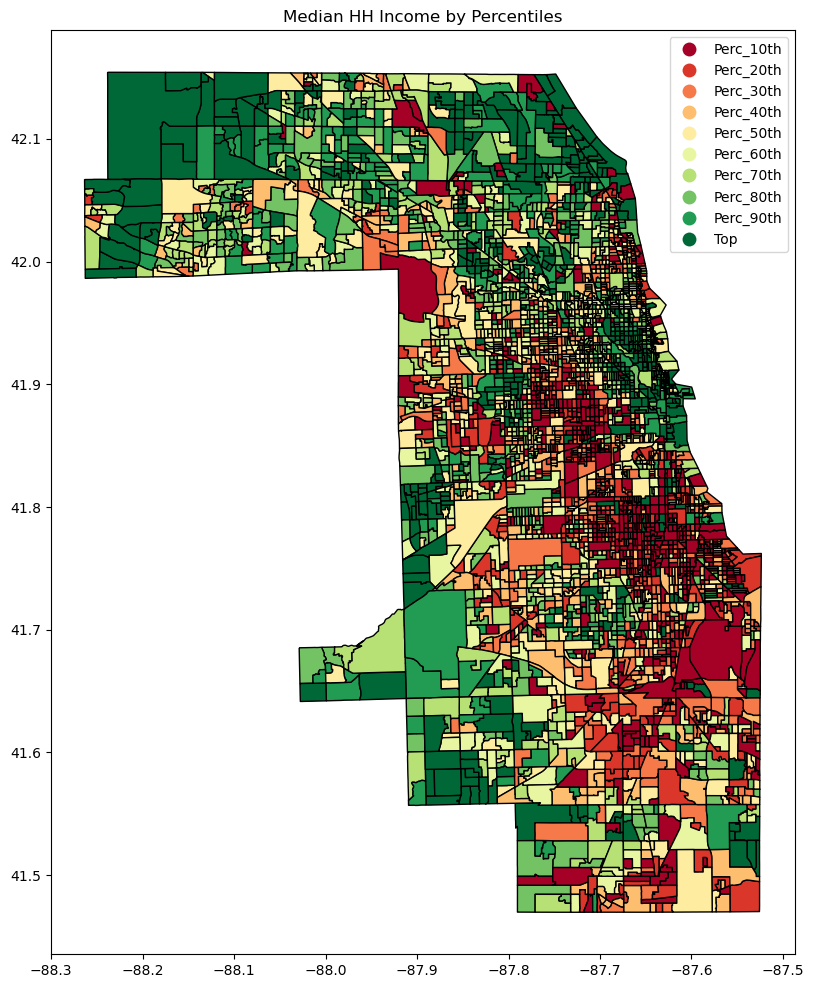

In [49]:
df.plot(column="bg_inc_deciles", figsize=[18,12],cmap="RdYlGn", legend=True, edgecolor='black')
plt.title("Median HH Income by Percentiles")

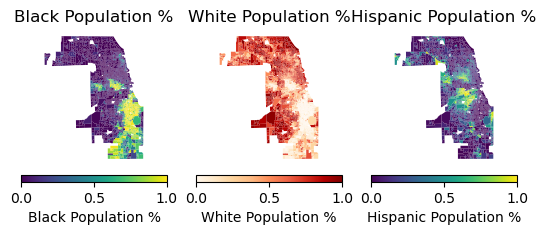

In [50]:
#income, bach, unemployed
# black, white,hispanic, density


fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1 = df.plot(ax=ax1, column='perc_black', legend=True, cax=cax1,
             legend_kwds ={'label': "Black Population %",'orientation': "horizontal"})
ax1.set_title("Black Population %")
ax1.set_axis_off();

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2 = df.plot(ax=ax2, column='perc_white', legend=True, cax=cax2, cmap='OrRd',
             legend_kwds ={'label': "White Population %", 'orientation': "horizontal"})
ax2.set_title("White Population %")
ax2.set_axis_off();

divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3 = df.plot(ax=ax3, column='perc_hispanic', legend=True, cax=cax3, 
             legend_kwds ={'label': "Hispanic Population %", 'orientation': "horizontal"})
ax3.set_title("Hispanic Population %")
ax3.set_axis_off();


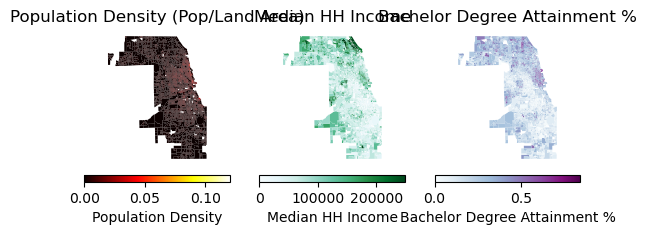

In [51]:
#-----------------
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1 = df.plot(ax=ax1, column='pop_density', legend=True, cax=cax1, cmap='hot',
             legend_kwds ={'label': "Population Density",'orientation': "horizontal"})
ax1.set_title("Population Density (Pop/Land Area)")
ax1.set_axis_off();

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2 = df.plot(ax=ax2, column='income_medhh', legend=True, cax=cax2, cmap='BuGn',
             legend_kwds ={'label': "Median HH Income", 'orientation': "horizontal"})
ax2.set_title("Median HH Income")
ax2.set_axis_off();

divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3 = df.plot(ax=ax3, column='perc_bachelor', legend=True, cax=cax3, cmap='BuPu',
             legend_kwds ={'label': "Bachelor Degree Attainment %", 'orientation': "horizontal"})
ax3.set_title("Bachelor Degree Attainment %")
ax3.set_axis_off();
#by community, bar of

/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


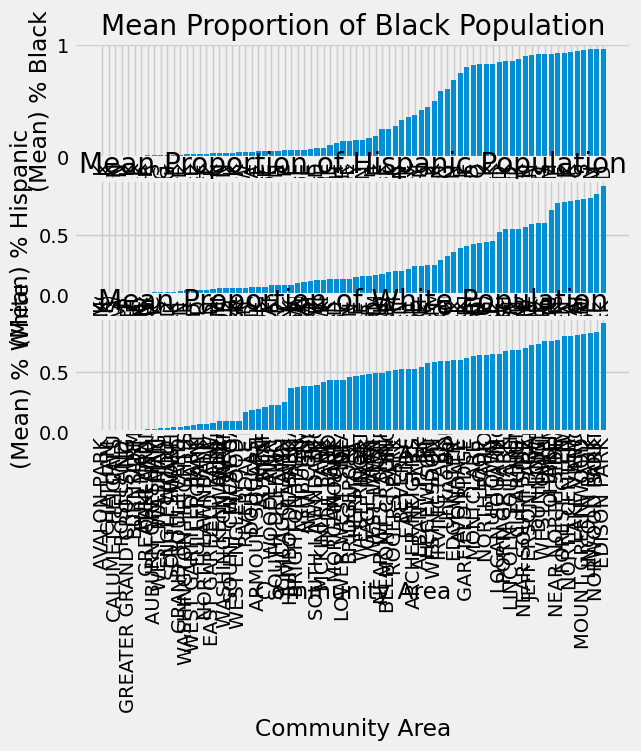

In [403]:
blackByComm = df.groupby("community")["perc_black"].mean().sort_values()
hispanicByComm = df.groupby("community")["perc_hispanic"].mean().sort_values()
whiteByComm = df.groupby("community")["perc_white"].mean().sort_values()


fig, (ax, ax2,ax3) = plt.subplots(3,1, constrained_layout=True)

ax.bar(blackByComm.index, blackByComm)
ax.set_title("Mean Proportion of Black Population")
ax.set_xlabel("Community Area")
ax.set_ylabel("(Mean) % Black")
# Rotating X-axis labels
#ax.set_xticklabels(ax.get_xticks(), rotation = 90)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax2.bar(hispanicByComm.index, hispanicByComm)
ax2.set_title("Mean Proportion of Hispanic Population")
ax2.set_xlabel("Community Area")
ax2.set_ylabel("(Mean) % Hispanic")
#plt.xticks(rotation = 90)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

ax3.bar(whiteByComm.index, whiteByComm)
ax3.set_title("Mean Proportion of White Population")
ax3.set_xlabel("Community Area")
ax3.set_ylabel("(Mean) % White")
plt.xticks(rotation = 90)


"""to adjust whitespace between plots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
"""
plt.show()

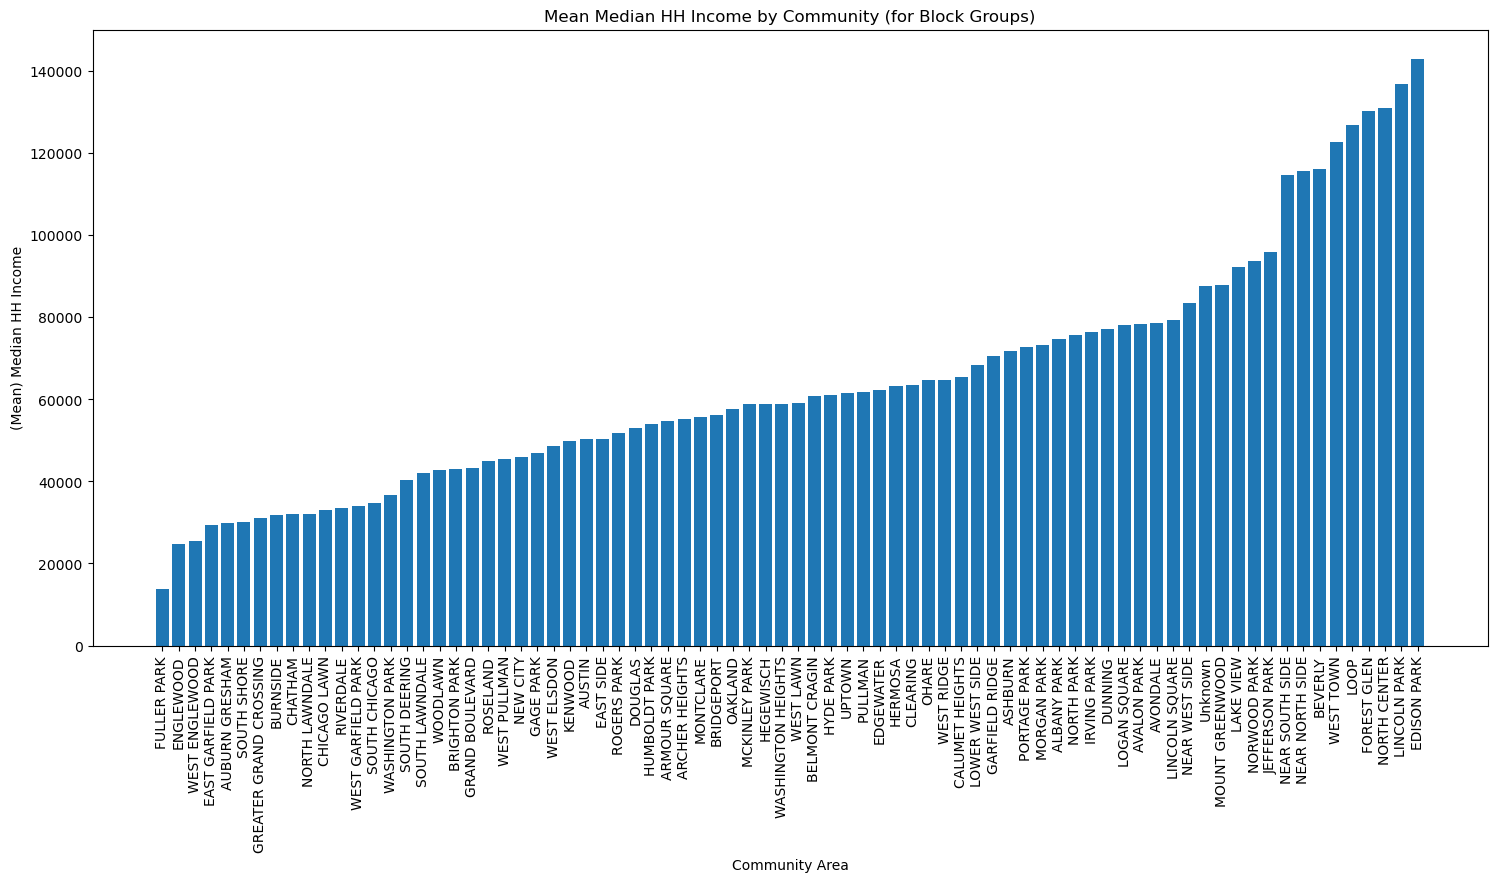

In [54]:
#by community, bar of race
#how affluent
incomeByComm = df.groupby("community")["income_medhh"].mean().sort_values()

fig, ax = plt.subplots(figsize=[18,8])
ax.bar(incomeByComm.index, incomeByComm)
ax.set_title("Mean Median HH Income by Community (for Block Groups)")
ax.set_xlabel("Community Area")
ax.set_ylabel("(Mean) Median HH Income")
plt.xticks(rotation = 90)

plt.show()

3992


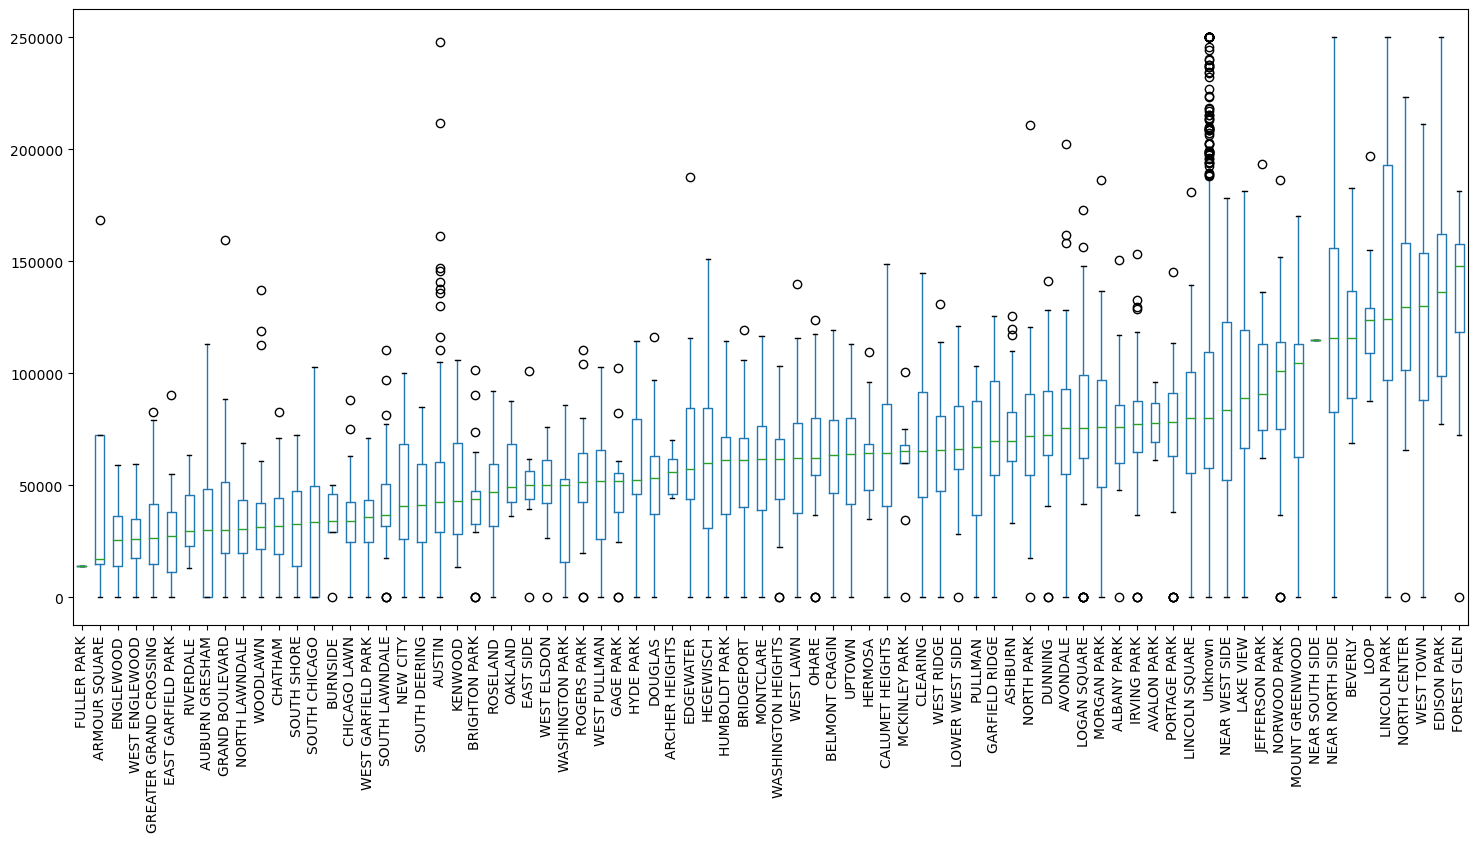

In [55]:
# Want to see the distribution of income across communities per bg. how diverse are communities economically by block?
# make a column where geometry is converted to string, so can pivot/make wide data

df["bg_geometry"] = df["geometry"].astype("str")

#make wide, where each community is a column, each row is a geometry(bg)
v= df.pivot(index="bg_geometry", columns="community", values="income_medhh")
print(len(v))

# use this to sort the boxplot by medians
srt=v.median().sort_values()
v[srt.index].boxplot(figsize=[18,8], grid= False)

plt.xticks(rotation = 90)
plt.show()

### What other analysis might be interesting here? Keep the main objective in focus.
* Eventually estimating rental prices based on these data
* Making an interactive tool that will help me decide what areas to live in

# <font color='green'>Adding in More Data (By Spatial Joins)</font>

In [56]:
"""
cta_df 
crime_df 
biz_df 
rental_df 
"""

'\ncta_df \ncrime_df \nbiz_df \nrental_df \n'

In [57]:
#cta_df # would need to "join" by seeing which polygons the lat/long falls into
#crime_df # same for joining here as well. This data has some time series potential
#biz_df # would need same join method with polygons lat longs. some of these need to convert address to lat/long.
#may have some ts potential as well with date issued

#rental_df # same for lat/longs. 

#Adding rentals will blow out the block group level stats because will repeat. 
#Actually adding any of these will blow out the stats and will
#have to take an avg if want to visualize

In [58]:
df.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'community', 'GISJOIN', 'TRACTA', 'BLKGRPA', 'GEO_ID',
       'pop_total', 'emp_total', 'perc_white', 'perc_black', 'perc_hispanic',
       'perc_asian', 'perc_native', 'perc_other', 'perc_mixed', 'perc_hsgrad',
       'perc_bachelor', 'perc_>bachelor', 'income_medhh', 'perc_inLaborForce',
       'perc_employed', 'perc_unemployed', 'comm_test', 'pop_density',
       'bg_inc_deciles', 'bg_geometry'],
      dtype='object')

Coordinate Reference System (crs) gives context to how our points/coordinates should be interpreted/related to places on earth, rather than what they start off as, which is geometric shapes in arbitrary space. 
Most commonly used CRS is the WGS84 latitude-longitude projection (authority code "EPSG:4326").

new_df = gpd.sjoin(A,B,how="inner", op='intersects')

Make sure they're using the same projection reference

pointdf.crs = polydf.crs

#Checking the projections

df["geometry"].crs 


## <font color='red'>Crime</font>

* Date from object to DateType. Month/Year
* to geo_pandas
* lat/long to geometry


In [59]:
crime_df = pd.read_csv(data_path + "Crimes_-_2020.csv")


In [60]:
print(len(crime_df["Location Description"].drop_duplicates()))
print(len(crime_df["Description"].drop_duplicates()))
print(len(crime_df["Primary Type"].drop_duplicates()))

166
419
33


In [61]:
crime_df.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [62]:
crime_df["Date"] = pd.to_datetime(crime_df["Date"])
crime_df["YearMonth"] = crime_df["Date"].dt.to_period('M')

In [63]:
crime = crime_df[["Case Number", "Date", "YearMonth", "Primary Type","Description", 
                  "Location Description", "Arrest", "Domestic", "Latitude", "Longitude"]]


In [64]:
crimeYM = pd.DataFrame(crime.groupby(["YearMonth", "Primary Type"])["Case Number"].count())
crimeYM.reset_index(inplace=True)

In [65]:
crimeType = pd.DataFrame(crimeYM.groupby(["Primary Type"])["Case Number"].sum())#.reset_index(inplace=True)

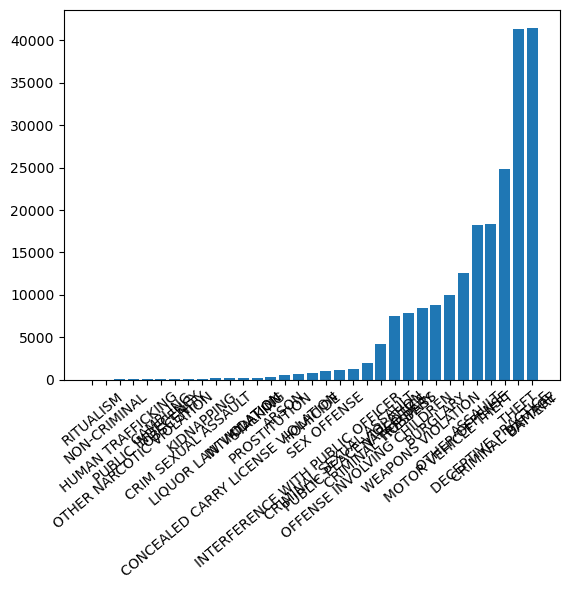

In [66]:
#crimeYM
crimeType.sort_values('Case Number',inplace=True)
plt.bar(crimeType.index, crimeType["Case Number"])
# Rotating X-axis labels
plt.xticks(rotation = 40)
plt.show()

In [67]:
#crimeYM
# pivot the data into the correct shape. Data Needs to be wide where each crime type is a column
# in order to be able to plot each type as it's own line on the graph
crimeYM_wide = crimeYM.pivot(index='YearMonth', columns='Primary Type', values='Case Number')

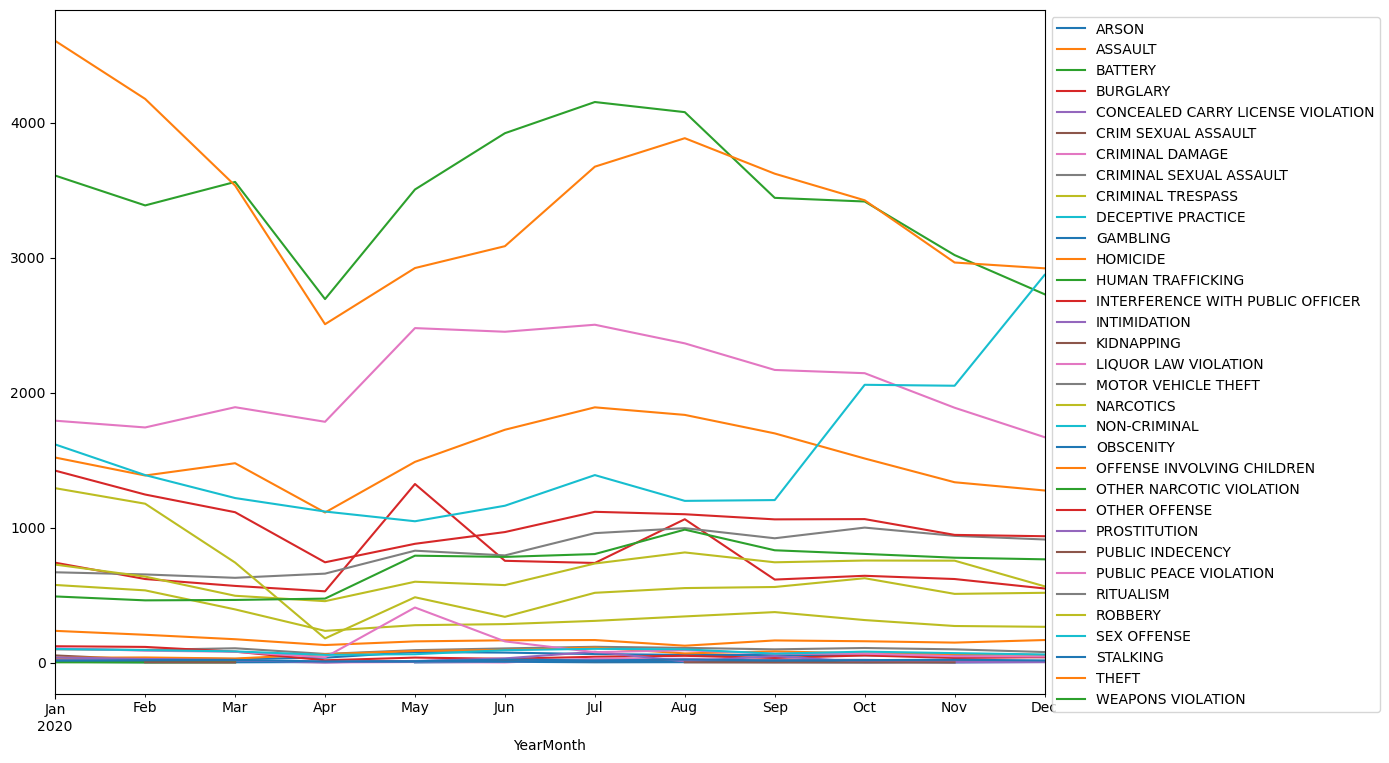

In [68]:
crimeYM_wide.plot( figsize=(14, 8))
# get the legend outside of the plot
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

Create my own crime catagories to have more succinct analysis when data is joined

In [69]:
crime["crime_cat"] = np.where(crime["Primary Type"].isin(["ASSAULT", "BATTERY"]), "Violent Crime",
                             np.where(crime["Primary Type"].isin(["CRIM SEXUAL ASSAULT", "CRIMINAL SEXUAL ASSAULT"]), "Sexual Assault",
                                     np.where(crime["Primary Type"].isin(["MOTOR VEHICLE THEFT", "ROBBERY", "THEFT"]), "Theft",
                                             np.where(crime["Primary Type"] == "HOMICIDE", "Homicide",
                                                     np.where(crime["Primary Type"].isin(["NARCOTICS", "OTHER NARCOTIC VIOLATION"]),"Narcotics",
                                                             "Other")))))



/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
len(crime)

212224

In [71]:
# Make a crime geopandas frame and convert lat long to geometry
gdf_crime = gpd.GeoDataFrame(
    crime[["Case Number", "YearMonth","crime_cat","Arrest","Latitude", "Longitude"]], 
    geometry=gpd.points_from_xy( crime["Longitude"], crime["Latitude"])#, crs="EPSG:4269"
)

gdf_crime.drop(columns=["Longitude", "Latitude"], inplace=True)
#https://geopandas.org/en/latest/gallery/create_geopandas_from_pandas.html

/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


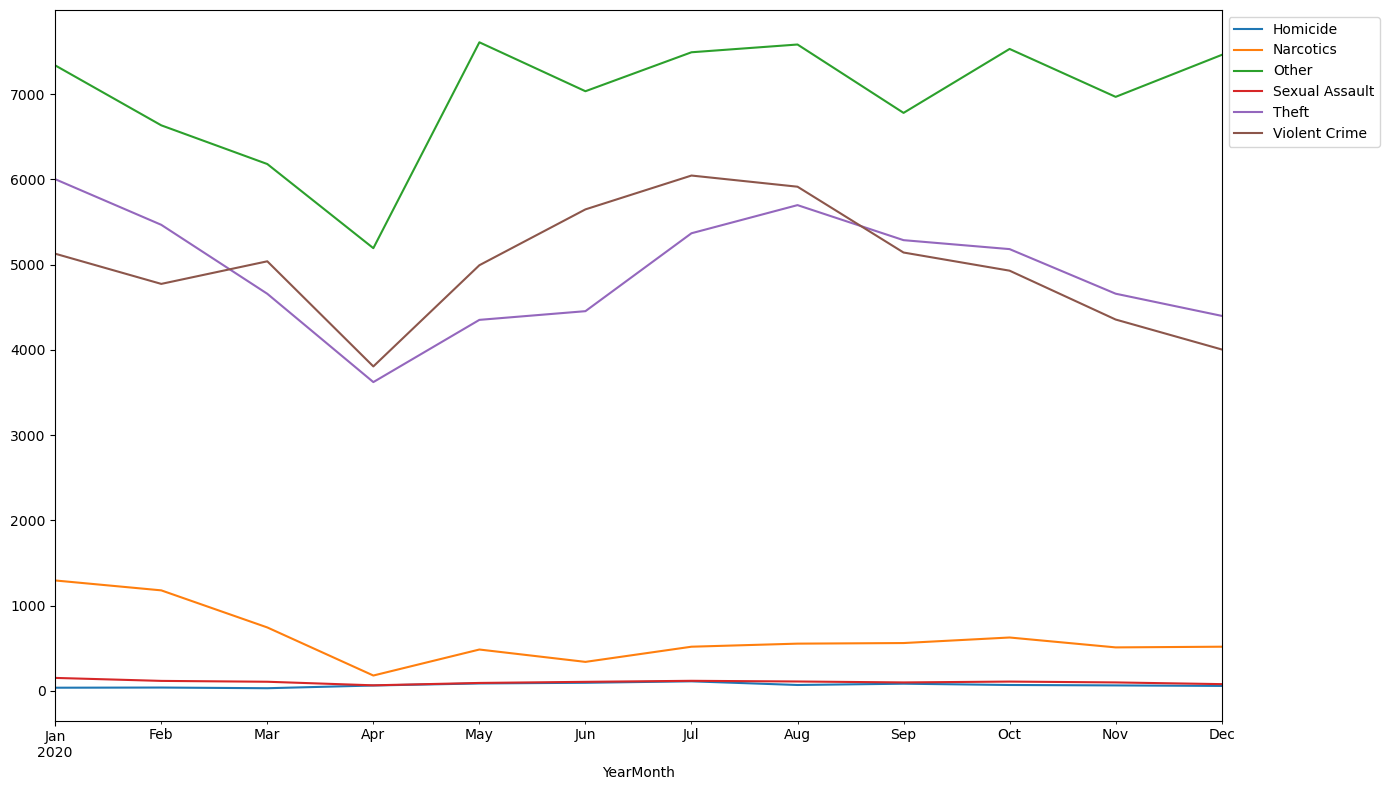

In [72]:
crime_wide = pd.DataFrame(gdf_crime.groupby(["YearMonth", "crime_cat"])["Case Number"].count()).\
rename(columns={"Case Number": "crime_count"}).\
reset_index().pivot(index="YearMonth", columns="crime_cat", values="crime_count")

crime_wide.plot( figsize=(14, 8))
# get the legend outside of the plot
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

In [73]:
# at this point df is our census block groups, with community areas and census data added for the block groups
len(df)

3992

In [74]:
# what we want is to be able to allocate each crime (point) to a block group on a join

In [75]:
gdf_crime

Case Number YearMonth      crime_cat  Arrest  \
0         JD226426   2020-05          Theft   False   
1         JD209965   2020-04  Violent Crime    True   
2         JD282112   2020-07  Violent Crime    True   
3         JD381597   2020-09  Violent Crime   False   
4         JD321064   2020-08          Other    True   
...            ...       ...            ...     ...   
212219    JD327752   2020-08          Other   False   
212220    JD269218   2020-06          Theft   False   
212221    JD311791   2020-07  Violent Crime   False   
212222    JD340297   2020-08          Theft   False   
212223    JD177406   2020-03          Other   False   

                          geometry  
0       POINT (-87.62175 41.83048)  
1       POINT (-87.63962 41.83631)  
2       POINT (-87.54918 41.74761)  
3       POINT (-87.67137 41.77488)  
4       POINT (-87.65848 41.74622)  
...                            ...  
212219  POINT (-87.69810 41.77267)  
212220  POINT (-87.61421 41.72455)  
212221  POINT (-87.70946 41.87092)  
212222  POINT (-87.68893 41.99593)  
212223  POINT (-87.66146 41.94211)  

[212224 rows x 5 columns]

In [76]:
# to preserve the crime points geometry after the join
gdf_crime["crime_geo"] = gdf_crime["geometry"].astype("str")

In [77]:
gdf_crime.dtypes

Case Number       object
YearMonth      period[M]
crime_cat         object
Arrest              bool
geometry        geometry
crime_geo         object
dtype: object

In [78]:
# Make sure they're using the same projection reference
df.crs = gdf_crime.crs

df1 =gpd.sjoin(df, gdf_crime,  how="left", op="intersects").reset_index(drop=True)

df1.drop(columns=["index_right"], inplace=True)

In [79]:
df1.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      17      031  813400        1  170318134001  Block Group 1  G5030   
1      17      031  813400        1  170318134001  Block Group 1  G5030   
2      17      031  813400        1  170318134001  Block Group 1  G5030   
3      17      031  820502        2  170318205022  Block Group 2  G5030   
4      17      031  672000        3  170316720003  Block Group 3  G5030   

  FUNCSTAT   ALAND  AWATER  ... perc_unemployed comm_test pop_density  \
0        S  415954       0  ...        0.019553     Other    0.003544   
1        S  415954       0  ...        0.019553     Other    0.003544   
2        S  415954       0  ...        0.019553     Other    0.003544   
3        S  455769       0  ...        0.033939   Unknown    0.002067   
4        S  184727       0  ...        0.198324     Other    0.002127   

  bg_inc_deciles                                        bg_geometry  \
0      Perc_10th  POLYGON ((-87.76798599999999 41.86554599999999...   
1      Perc_10th  POLYGON ((-87.76798599999999 41.86554599999999...   
2      Perc_10th  POLYGON ((-87.76798599999999 41.86554599999999...   
3      Perc_10th  POLYGON ((-87.80959299999999 41.753446, -87.80...   
4      Perc_10th  POLYGON ((-87.674745 41.764799, -87.6745019999...   

  Case Number YearMonth      crime_cat  Arrest  \
0    JD292547   2020-07          Other   False   
1    JD137726   2020-02          Theft   False   
2    JD342506   2020-08  Violent Crime   False   
3         NaN       NaT            NaN     NaN   
4    JD210831   2020-04          Other   False   

                                 crime_geo  
0       POINT (-87.765856246 41.865573795)  
1       POINT (-87.765856246 41.865573795)  
2       POINT (-87.765856246 41.865573795)  
3                                      NaN  
4  POINT (-87.67383535499999 41.764803632)  

[5 rows x 43 columns]

209666


<AxesSubplot:>

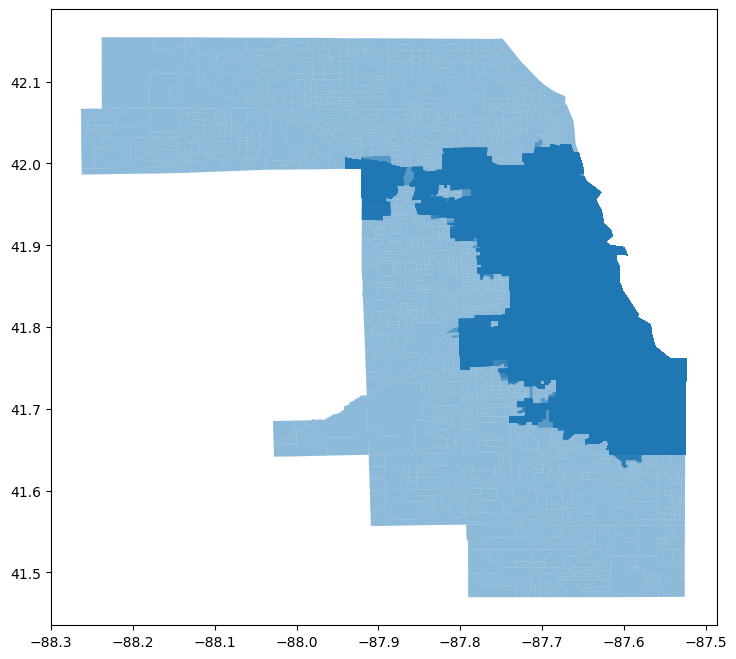

In [80]:
print(len(df1))

df1.plot(alpha=0.5, figsize=[15,8])

# I think this happens because after we make the sjoin with crime, our polygon geometry will have duplicates because
# more than one crime point will appear in a bg/geometry. so a duplicate will need to be created to accomodate.
#maybe the next step is to group by the polygon and get crime counts, or crime wide

In [83]:
df1["geometry"].head(3)

0    POLYGON ((-87.76799 41.86555, -87.76774 41.865...
1    POLYGON ((-87.76799 41.86555, -87.76774 41.865...
2    POLYGON ((-87.76799 41.86555, -87.76774 41.865...
Name: geometry, dtype: geometry

In [84]:
df1.dtypes

STATEFP                 object
COUNTYFP                object
TRACTCE                 object
BLKGRPCE                object
GEOID                   object
NAMELSAD                object
MTFCC                   object
FUNCSTAT                object
ALAND                    int64
AWATER                   int64
INTPTLAT                object
INTPTLON                object
geometry              geometry
community               object
GISJOIN                 object
TRACTA                  object
BLKGRPA                 object
GEO_ID                  object
pop_total              float64
emp_total              float64
perc_white             float64
perc_black             float64
perc_hispanic          float64
perc_asian             float64
perc_native            float64
perc_other             float64
perc_mixed             float64
perc_hsgrad            float64
perc_bachelor          float64
perc_>bachelor         float64
income_medhh           float64
perc_inLaborForce      float64
perc_emp

In [85]:
print(len(df1))
print(len(df1[df1["crime_cat"].isna()]))
df1.head(3)

209666
1719


STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      17      031  813400        1  170318134001  Block Group 1  G5030   
1      17      031  813400        1  170318134001  Block Group 1  G5030   
2      17      031  813400        1  170318134001  Block Group 1  G5030   

  FUNCSTAT   ALAND  AWATER  ... perc_unemployed comm_test pop_density  \
0        S  415954       0  ...        0.019553     Other    0.003544   
1        S  415954       0  ...        0.019553     Other    0.003544   
2        S  415954       0  ...        0.019553     Other    0.003544   

  bg_inc_deciles                                        bg_geometry  \
0      Perc_10th  POLYGON ((-87.76798599999999 41.86554599999999...   
1      Perc_10th  POLYGON ((-87.76798599999999 41.86554599999999...   
2      Perc_10th  POLYGON ((-87.76798599999999 41.86554599999999...   

  Case Number YearMonth      crime_cat  Arrest  \
0    JD292547   2020-07          Other   False   
1    JD137726   2020-02          Theft   False   
2    JD342506   2020-08  Violent Crime   False   

                            crime_geo  
0  POINT (-87.765856246 41.865573795)  
1  POINT (-87.765856246 41.865573795)  
2  POINT (-87.765856246 41.865573795)  

[3 rows x 43 columns]

<AxesSubplot:>

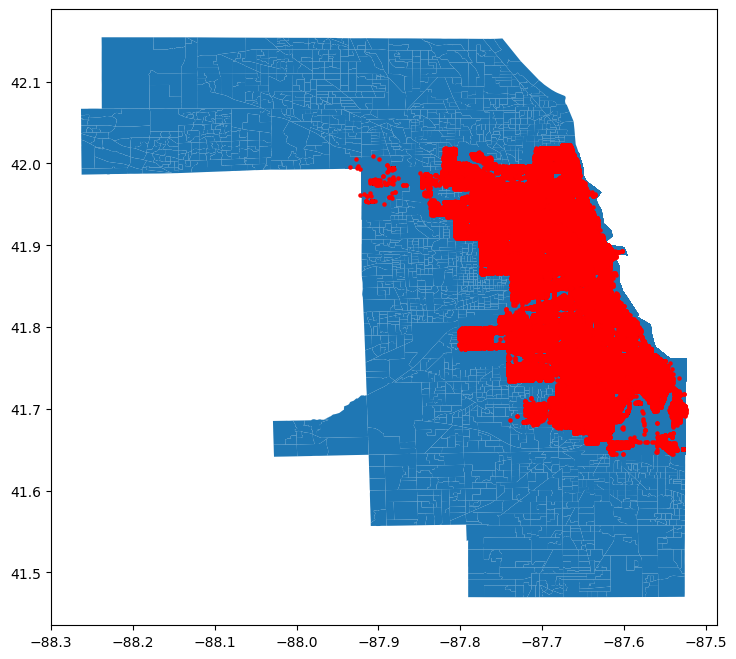

In [86]:
f, ax = plt.subplots(figsize=[12,8])
df1["geometry"].plot(ax=ax)
gdf_crime.plot(ax=ax, color='red', markersize=5)

Next Steps:
* businesses and homes still need to be added to the dataset (last thing on the list)
* do some geo analysis about crime
    * Which communities have higher crime and of what type?
    * Which communities have higher arrest rates? Does this differ by crime type?
    * are there synergies between crime and the demographic data
* can we make some maps exhibing demographic distribution in the city? (can probably do this in the section before crime)
* take some time to dig deeper in plotting with matplotlib...these plots could look a lot better.
* document the journey through blog posts...think about how will break out what I've done so far?
    * Forming a goal/problem
    * Finding a dataset
    * Pulling together different datasets
    * Exploratory analysis
    * Geopandas and spatial analysis
    * virtual environments
    * haven't done this yet, but thinking about the efficacy of your data. Want to write something about how nghis compiles their data, the assumptions they make, and the statistical ranges they employ (b/c the census data wasn't actually collected).
    

In [87]:


#could make a df where crime counts for each cat is a column and join in back on the original frame.
#the issue is that we want to count these crimes at the block group level, so I don't see a way around grouping by geometry
#df1["geometry"].to_wkt()
"""
out = pts.groupby(['id', pts['geometry'].to_wkt()]).agg(prom_revenue=('prix', np.mean)).reset_index()
out.columns = ['id', 'geometry', 'pro_revenue']
out['geometry'] = gp.GeoSeries.from_wkt(out['geometry'])
out = gp.GeoDataFrame(out)
print(out)"""

"\nout = pts.groupby(['id', pts['geometry'].to_wkt()]).agg(prom_revenue=('prix', np.mean)).reset_index()\nout.columns = ['id', 'geometry', 'pro_revenue']\nout['geometry'] = gp.GeoSeries.from_wkt(out['geometry'])\nout = gp.GeoDataFrame(out)\nprint(out)"

In [88]:
# get crime counts by block group

k = pd.DataFrame(df1.groupby([df1["geometry"].astype("str"),"community","crime_cat"])["Case Number"].count())
k.reset_index().rename(columns={"Case Number":"crime_counts"})

# also add arrest counts by block group

geometry  community  \
0     POLYGON ((-87.53165799999999 41.702716, -87.53...  EAST SIDE   
1     POLYGON ((-87.53165799999999 41.702716, -87.53...  EAST SIDE   
2     POLYGON ((-87.53165799999999 41.702716, -87.53...  EAST SIDE   
3     POLYGON ((-87.53165799999999 41.702716, -87.53...  EAST SIDE   
4     POLYGON ((-87.531661 41.708219, -87.5314789999...  EAST SIDE   
...                                                 ...        ...   
9313  POLYGON ((-87.940247 42.007172, -87.940173 42....      OHARE   
9314  POLYGON ((-87.940247 42.007172, -87.940173 42....      OHARE   
9315  POLYGON ((-87.940247 42.007172, -87.940173 42....      OHARE   
9316  POLYGON ((-87.940247 42.007172, -87.940173 42....      OHARE   
9317  POLYGON ((-87.959935 42.02516, -87.95959099999...      OHARE   

          crime_cat  crime_counts  
0         Narcotics             2  
1             Other            14  
2             Theft             7  
3     Violent Crime            17  
4             Other            15  
...             ...           ...  
9313      Narcotics            88  
9314          Other           207  
9315          Theft           185  
9316  Violent Crime           104  
9317          Other             1  

[9318 rows x 4 columns]

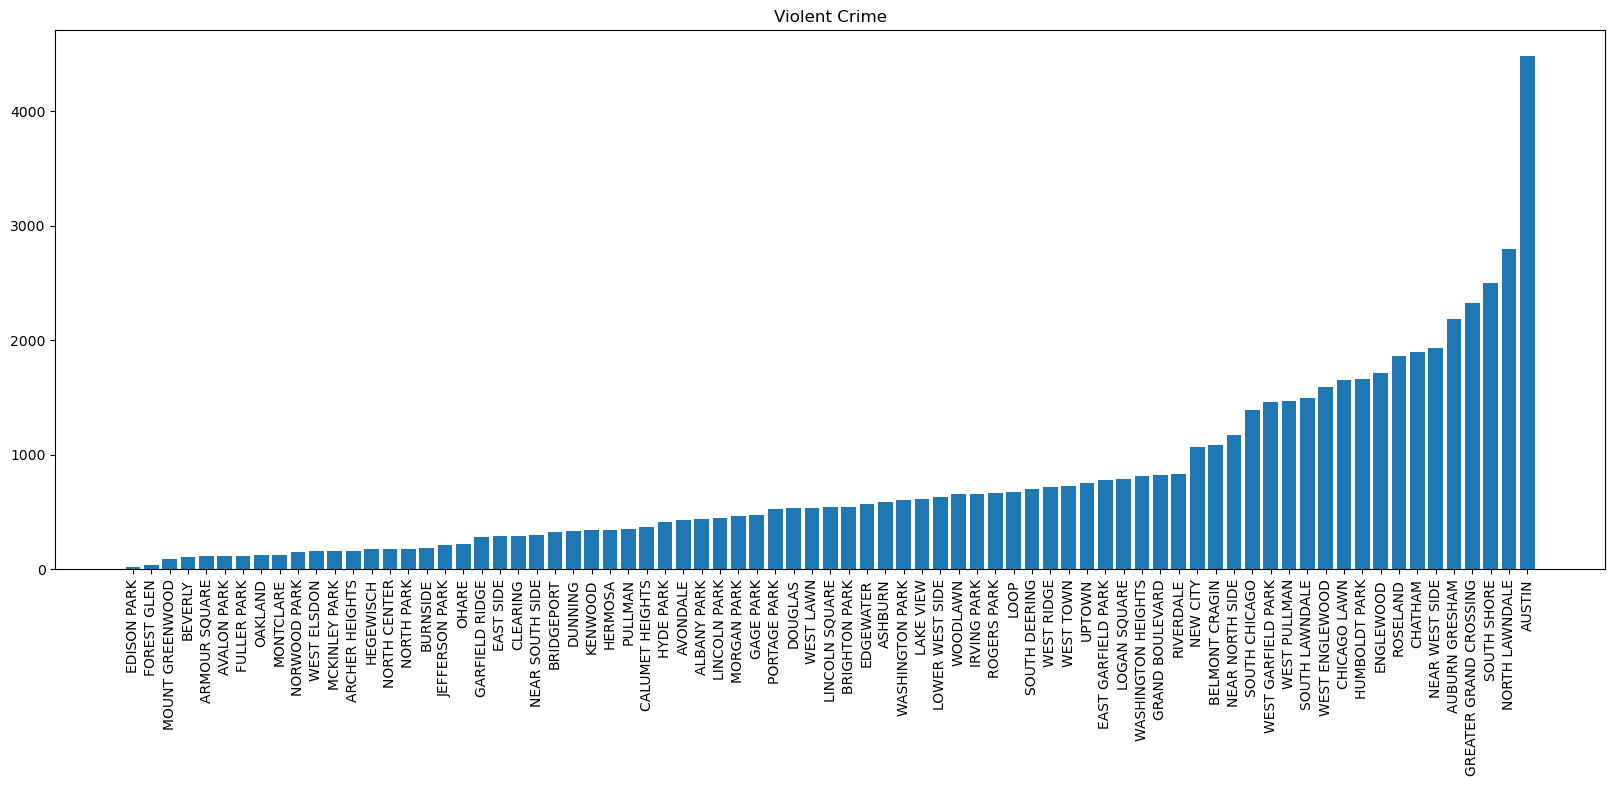

In [89]:
ccat="Violent Crime"
byTheft = df1[df1["crime_cat"] == ccat].groupby(["community"])["Case Number"].count().sort_values()
#byTheft = df1[df1["crime_cat"] == "Theft"].groupby(["community"])["Case Number"].count().sort_values()

#Homicide, Sexual Assault, Violent Crime, Narcotics

fig, ax = plt.subplots(figsize = [20,7])
ax.bar(byTheft.index, byTheft)
plt.title(ccat)
plt.xticks(rotation = 90)
plt.show()

Text(0.5, 1.0, 'Theft')

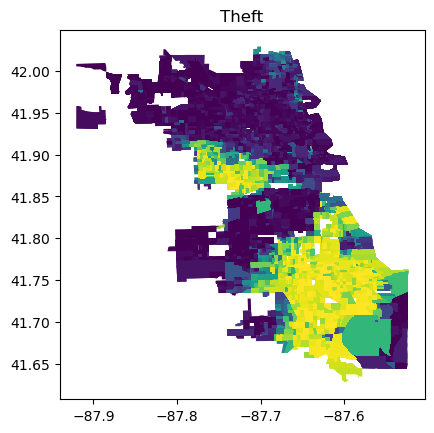

In [90]:
fig, ax = plt.subplots()
ax1 = df1[df1["crime_cat"] == "Theft"].plot(ax=ax, column='perc_black', legend=True, cax=cax1,
             legend_kwds ={'label': "Theft",'orientation': "horizontal"})
ax1.set_title("Theft")


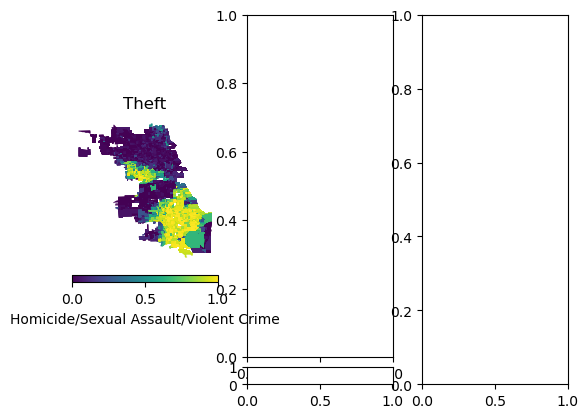

In [91]:
# Where is the crime?
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1 = df1[df1["crime_cat"] == "Theft"].plot(ax=ax1, column='perc_black', legend=True, cax=cax1,
             legend_kwds ={'label': "Theft",'orientation': "horizontal"})
ax1.set_title("Theft")
ax1.set_axis_off()

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2 = df1[df1["crime_cat"].isin(["Homicide", "Sexual Assault", "Violent Crime"])].plot(ax=ax1, column='perc_black', legend=True, cax=cax1,
             legend_kwds ={'label': "Homicide/Sexual Assault/Violent Crime",'orientation': "horizontal"})
ax2.set_title("Theft")
ax2.set_axis_off()

# Sidebar - Predicting Rental Prices

In [104]:
rental_df1 = pd.read_csv(data_path + "Chicago_Rentals_Sample_Oct1923.csv")
rental_df2 = pd.read_csv(data_path + "Chicago_Rentals_Sample_Dec2023.csv")

rental_df = pd.concat([rental_df1, rental_df2], ignore_index=True).drop(columns=["Unnamed: 0"]).drop_duplicates()
print(len(rental_df))
print(rental_df.columns)


5809


Index(['property_id', 'listing_id', 'prop_type', 'latitude', 'longitude',
       'address', 'price', 'price_max', 'price_min', 'link', 'description'],
      dtype='object')

In [105]:
desc_lst = rental_df["description"]
desc_lst

0       { beds :null, beds_max :2, beds_min :1, baths_...
1       { beds :null, beds_max :2, beds_min :0, baths_...
2       { beds :null, beds_max :3, beds_min :1, baths_...
3       { beds :null, beds_max :2, beds_min :2, baths_...
4       { beds :null, beds_max :3, beds_min :1, baths_...
                              ...                        
7807    { beds :2, beds_max :null, beds_min :null, bat...
7808    { beds :1, beds_max :null, beds_min :null, bat...
7809    { beds :1, beds_max :null, beds_min :null, bat...
7810    { beds :1, beds_max :null, beds_min :null, bat...
7811    { beds :1, beds_max :null, beds_min :null, bat...
Name: description, Length: 5809, dtype: object

In [126]:
def clean_description(x):
    """ This function is to break out important info from description column of rentals data.
    need to put in a safety in case the value is null. the int() will cause an error"""
    lst = x.split(",")
    try: 
        beds = int(lst[0].split(":")[1])
    except: beds= 'NA'
        
    try:
        beds_max = int(lst[1].split(":")[1])
    except: beds_max = 'NA'
    
    try:
        beds_min = int(lst[2].split(":")[1])
    except:
        beds_min = 'NA'
    
    try:
        baths_min = float(lst[3].split(":")[1])
    except:
        baths_min = 'NA'
    try:
        baths_max = float(lst[4].split(":")[1])
    except:
        baths_max = 'NA'
    try:
        sqft_max = int(lst[10].split(":")[1])
    except:
        sqft_max ='NA'
    try:
        sqft_min = int(lst[11].split(":")[1])
    except:
        sqft_min = 'NA'
        
    ptype = lst[14].split(":")[1]
    
    dic = {"beds": beds, "beds_max": beds_max, "beds_min":beds_min, "baths_min":baths_min, "baths_max":baths_max,
          "sqft_max":sqft_max, "sqft_min":sqft_min, "property":ptype}
    
    return dic
    
    

In [129]:
#apply the function to get new description columns
j= rental_df["description"].apply(clean_description)
rentals = rental_df.merge(pd.DataFrame(list(j)), left_index=True, right_index=True).\
    drop(columns=["description","prop_type"])
rentals.head(3)


['{ beds :null', ' beds_max :2', ' beds_min :1', ' baths_min :1', ' baths_max :2', ' baths_consolidated :null', ' garage :null', ' garage_min :null', ' garage_max :null', ' sqft :null', ' sqft_max :1321', ' sqft_min :462', ' name : Noca Blu ', ' sub_type :null', ' type : apartment ', ' year_built :null']
--------
['{ beds :null', ' beds_max :2', ' beds_min :0', ' baths_min :1', ' baths_max :1', ' baths_consolidated :null', ' garage :null', ' garage_min :null', ' garage_max :null', ' sqft :null', ' sqft_max :915', ' sqft_min :400', ' name : 1735 W 79th ', ' sub_type :null', ' type : apartment ', ' year_built :null']
--------
['{ beds :null', ' beds_max :3', ' beds_min :1', ' baths_min :1', ' baths_max :1', ' baths_consolidated :null', ' garage :null', ' garage_min :null', ' garage_max :null', ' sqft :null', ' sqft_max :1125', ' sqft_min :770', ' name : 4653 W Jackson Blvd ', ' sub_type :null', ' type : apartment ', ' year_built :null']
--------
['{ beds :null', ' beds_max :2', ' beds_mi

property_id  listing_id   latitude  longitude                address  \
0   9007626047  2959645239  41.923980 -87.697593  2340 N California Ave   
1   8002932843  2949506142  41.750045 -87.667300         1735 W 79TH ST   
2   8609982816  2949505883  41.876605 -87.742419    4653 W JACKSON BLVD   

   price  price_max  price_min  \
0    NaN     3380.0     3380.0   
1    NaN      760.0      760.0   
2    NaN      980.0      980.0   

                                                link beds beds_max beds_min  \
0  https://www.realtor.com/realestateandhomes-det...   NA        2        1   
1  https://www.realtor.com/realestateandhomes-det...   NA        2        0   
2  https://www.realtor.com/realestateandhomes-det...   NA        3        1   

  baths_min baths_max sqft_max sqft_min     property  
0       1.0       2.0     1321      462   apartment   
1       1.0       1.0      915      400   apartment   
2       1.0       1.0     1125      770   apartment

In [130]:
# Make a rental geopandas frame and convert lat long to geometry
rentals = gpd.GeoDataFrame(
    rentals,
    geometry=gpd.points_from_xy( rentals["longitude"], rentals["latitude"])#, crs="EPSG:4269"
)

rentals.drop(columns=["longitude", "latitude"], inplace=True)
#https://geopandas.org/en/latest/gallery/create_geopandas_from_pandas.html

/opt/anaconda3/envs/ls_geo_env/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [404]:
"""f, ax = plt.subplots(figsize=[12,8])
df["geometry"].plot(ax=ax)
rentals.plot(ax=ax, color='red', markersize=5)
plt.title("Rentals")
"""

'f, ax = plt.subplots(figsize=[12,8])\ndf["geometry"].plot(ax=ax)\nrentals.plot(ax=ax, color=\'red\', markersize=5)\nplt.title("Rentals")\n'

In [132]:
# now we would want to join the rentals with the demo/crime data. For this dataset, since our objective focuses on rents,
# we would just want rows for rentals and nothing extra. rental dataset would be the dominant geometry.



In [133]:
# get crime counts wide per bg geometry
crime_cnts= df1.groupby(["bg_geometry","crime_cat"]).agg({"Case Number": "count"}).reset_index().\
    rename(columns={"Case Number":"Cnt"}). \
    pivot(index="bg_geometry", columns="crime_cat", values=["Cnt"]).reset_index()#.\

crime_cnts.columns = crime_cnts.columns.map('_'.join)

crime_cnts = crime_cnts.fillna(0)

crime_cnts.head(3)

bg_geometry_  Cnt_Homicide  \
0  POLYGON ((-87.53165799999999 41.702716, -87.53...           0.0   
1  POLYGON ((-87.531661 41.708219, -87.5314789999...           0.0   
2  POLYGON ((-87.53166499999999 41.692192, -87.53...           0.0   

   Cnt_Narcotics  Cnt_Other  Cnt_Sexual Assault  Cnt_Theft  Cnt_Violent Crime  
0            2.0       14.0                 0.0        7.0               17.0  
1            0.0       15.0                 0.0       15.0               13.0  
2            0.0       30.0                 0.0       17.0               12.0

In [134]:
# get arrests per bg geometry
arrests = df1.groupby(["bg_geometry"]).agg({"Arrest": "sum"}).reset_index().\
    rename(columns={"Case Number":"crime_cnt"})
arrests.head(3)

bg_geometry Arrest
0  POLYGON ((-87.529831 41.595744, -87.529831 41....      0
1  POLYGON ((-87.52987899999999 41.607268, -87.52...      0
2  POLYGON ((-87.52989199999999 41.613821, -87.52...      0

In [135]:
# merge crime and arrests with demographics to have a clear view of stuff at block group level
bg_base = df.merge(crime_cnts,how="left", left_on="bg_geometry", right_on="bg_geometry_").drop(columns= "bg_geometry_").\
    merge(arrests, how="left", on="bg_geometry")

bg_base.iloc[:,39:] = bg_base.iloc[:,39:].fillna(0)
bg_base.head(3)

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      17      031  813400        1  170318134001  Block Group 1  G5030   
1      17      031  820502        2  170318205022  Block Group 2  G5030   
2      17      031  672000        3  170316720003  Block Group 3  G5030   

  FUNCSTAT   ALAND  AWATER  ... pop_density bg_inc_deciles  \
0        S  415954       0  ...    0.003544      Perc_10th   
1        S  455769       0  ...    0.002067      Perc_10th   
2        S  184727       0  ...    0.002127      Perc_10th   

                                         bg_geometry Cnt_Homicide  \
0  POLYGON ((-87.76798599999999 41.86554599999999...          0.0   
1  POLYGON ((-87.80959299999999 41.753446, -87.80...          NaN   
2  POLYGON ((-87.674745 41.764799, -87.6745019999...          0.0   

  Cnt_Narcotics Cnt_Other Cnt_Sexual Assault Cnt_Theft  Cnt_Violent Crime  \
0           0.0       1.0                0.0       1.0                1.0   
1           0.0       0.0                0.0       0.0                0.0   
2           1.0      66.0                0.0      28.0               39.0   

   Arrest  
0       0  
1       0  
2      21  

[3 rows x 45 columns]

In [213]:
# rentals last to merge, as we would be just adding block group info for rentals.
bdf=gpd.sjoin(rentals, bg_base, how="left", op="intersects").reset_index(drop=True).\
    drop(columns=["index_right"]).drop_duplicates()
print(len(bdf))
bdf.head(3)

4427


property_id  listing_id                address  price  price_max  \
0   9007626047  2959645239  2340 N California Ave    NaN     3380.0   
1   8002932843  2949506142         1735 W 79TH ST    NaN      760.0   
2   8609982816  2949505883    4653 W JACKSON BLVD    NaN      980.0   

   price_min                                               link beds beds_max  \
0     3380.0  https://www.realtor.com/realestateandhomes-det...   NA        2   
1      760.0  https://www.realtor.com/realestateandhomes-det...   NA        2   
2      980.0  https://www.realtor.com/realestateandhomes-det...   NA        3   

  beds_min  ... pop_density bg_inc_deciles  \
0        1  ...    0.009839      Perc_60th   
1        0  ...    0.006108      Perc_10th   
2        1  ...    0.005548      Perc_10th   

                                         bg_geometry Cnt_Homicide  \
0  POLYGON ((-87.70231799999999 41.924763, -87.70...          0.0   
1  POLYGON ((-87.668291 41.750293, -87.668048 41....          0.0   
2  POLYGON ((-87.74514599999999 41.876808, -87.74...          1.0   

  Cnt_Narcotics Cnt_Other Cnt_Sexual Assault Cnt_Theft Cnt_Violent Crime  \
0           2.0      26.0                0.0      68.0              37.0   
1           1.0      57.0                1.0      30.0              59.0   
2          73.0      75.0                1.0      57.0              72.0   

  Arrest  
0     18  
1     21  
2    105  

[3 rows x 60 columns]

## Getting Insights Before Modeling
* data types
* Missing values
* Outliers
* variable distributions
* correlations
* New feature creation

In [214]:
# create a total crime column and a percent arrest

bdf["crime_tot"] = bdf.Cnt_Homicide + bdf.Cnt_Narcotics + bdf.Cnt_Other + bdf["Cnt_Sexual Assault"] + bdf.Cnt_Theft + bdf["Cnt_Violent Crime"]

bdf["arrest_perc"] = bdf["Arrest"]/bdf["crime_tot"]
bdf.head(3)

property_id  listing_id                address  price  price_max  \
0   9007626047  2959645239  2340 N California Ave    NaN     3380.0   
1   8002932843  2949506142         1735 W 79TH ST    NaN      760.0   
2   8609982816  2949505883    4653 W JACKSON BLVD    NaN      980.0   

   price_min                                               link beds beds_max  \
0     3380.0  https://www.realtor.com/realestateandhomes-det...   NA        2   
1      760.0  https://www.realtor.com/realestateandhomes-det...   NA        2   
2      980.0  https://www.realtor.com/realestateandhomes-det...   NA        3   

  beds_min  ...                                        bg_geometry  \
0        1  ...  POLYGON ((-87.70231799999999 41.924763, -87.70...   
1        0  ...  POLYGON ((-87.668291 41.750293, -87.668048 41....   
2        1  ...  POLYGON ((-87.74514599999999 41.876808, -87.74...   

  Cnt_Homicide Cnt_Narcotics Cnt_Other Cnt_Sexual Assault Cnt_Theft  \
0          0.0           2.0      26.0                0.0      68.0   
1          0.0           1.0      57.0                1.0      30.0   
2          1.0          73.0      75.0                1.0      57.0   

  Cnt_Violent Crime Arrest crime_tot arrest_perc  
0              37.0     18     133.0    0.135338  
1              59.0     21     148.0    0.141892  
2              72.0    105     279.0    0.376344  

[3 rows x 62 columns]

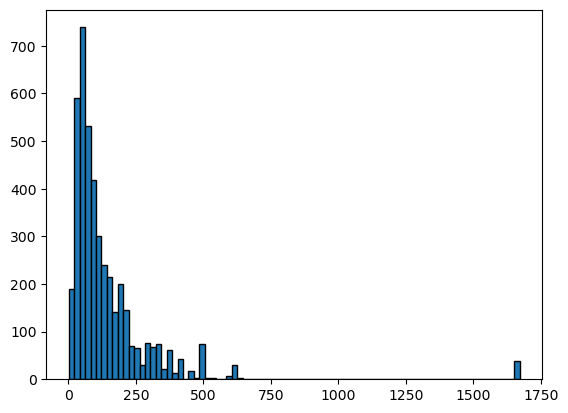

In [190]:
plt.hist(bdf["crime_tot"], edgecolor="black", bins = int(bdf["crime_tot"].max()/20))
plt.show()

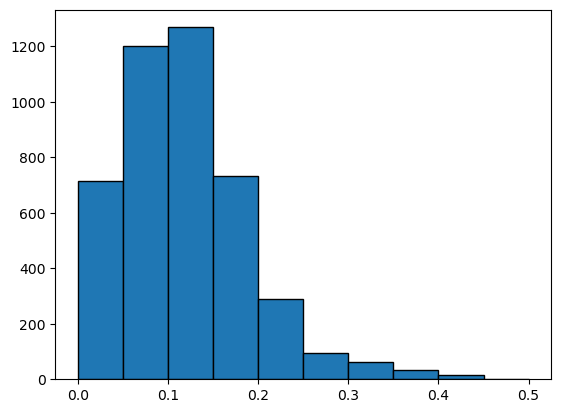

In [191]:
plt.hist(bdf["arrest_perc"], edgecolor="black")
plt.show()

In [215]:
# count missing values per column
missing_col=[bdf[i].isna().sum() for i in bdf.columns]
#bdf.isna().sum( axis=0)

missing_perc = [i/len(bdf) for i in missing_col]
missing_perc_df = pd.DataFrame({"col_name": bdf.columns, "prop_missing": missing_perc}).sort_values(by=['prop_missing'], ascending=False)
missing_perc_df


col_name  prop_missing
4           price_max      0.850915
5           price_min      0.850915
3               price      0.150440
44     perc_>bachelor      0.055342
46  perc_inLaborForce      0.055342
..                ...           ...
13           sqft_min      0.000000
14           property      0.000000
15           geometry      0.000000
1          listing_id      0.000000
0         property_id      0.000000

[62 rows x 2 columns]

In [199]:
bdf.iloc[:,-12:]#.replace("NA", 0)#.fillna(0)

Cnt_Narcotics  Cnt_Other  Cnt_Sexual Assault  Cnt_Theft  \
0               2.0       26.0                 0.0       68.0   
1               1.0       57.0                 1.0       30.0   
2              73.0       75.0                 1.0       57.0   
3               4.0       64.0                 1.0       57.0   
4               1.0       56.0                 2.0       21.0   
...             ...        ...                 ...        ...   
4422            0.0       35.0                 0.0       24.0   
4423            0.0       19.0                 1.0       27.0   
4424            0.0       35.0                 0.0       24.0   
4425            0.0       35.0                 0.0       24.0   
4426            0.0       20.0                 1.0       24.0   

      Cnt_Violent Crime  Arrest  crime_tot  arrest_perc  beds1  baths1 sqft1  \
0                  37.0    18.0      133.0     0.135338      0     1.0   462   
1                  59.0    21.0      148.0     0.141892      0     1.0   400   
2                  72.0   105.0      279.0     0.376344      0     1.0   770   
3                  54.0    24.0      180.0     0.133333      0     1.0   750   
4                  36.0    15.0      116.0     0.129310      0     1.0   700   
...                 ...     ...        ...          ...    ...     ...   ...   
4422                5.0     5.0       64.0     0.078125      2     0.0     0   
4423               10.0     5.0       58.0     0.086207      2     0.0     0   
4424                5.0     5.0       64.0     0.078125      1     0.0     0   
4425                5.0     5.0       64.0     0.078125      1     0.0     0   
4426                2.0     2.0       47.0     0.042553      1     0.0     0   

      price1  
0     3380.0  
1      760.0  
2      980.0  
3     1355.0  
4      945.0  
...      ...  
4422  5000.0  
4423  2700.0  
4424  3370.0  
4425  1900.0  
4426  3195.0  

[4427 rows x 12 columns]

Let's handle missing values. For beds, bath, and price will take minimums as default if a hard cut value is not provided.

In [195]:
#list(bdf.columns)
#bdf[bdf["beds1"] == "NA"]

In [216]:


bdf["beds1"] = np.where(bdf.beds == "NA", bdf.beds_min, bdf.beds)

bdf["baths1"] =  np.where(bdf.baths_min == "NA", bdf.baths_max, bdf.baths_min)
bdf["baths1"] =  np.where(bdf.baths1 == "NA", 0, bdf.baths1)

bdf["sqft1"] = np.where(bdf.sqft_min == "NA", bdf.sqft_max, bdf.sqft_min)
bdf["sqft1"] = np.where(bdf.sqft1 == "NA", 0 , bdf.sqft1 )

bdf["price1"] = np.where(bdf.price.isna(), bdf.price_min, bdf.price)

# NAs to 0
bdf.iloc[:,-12:] = bdf.iloc[:,-12:].fillna(0)
bdf.iloc[:,7:13] = bdf.iloc[:,7:13].replace("NA", 0)
bdf.iloc[:,3:6] = bdf.iloc[:,3:6].fillna(0)


bdf

property_id  listing_id                       address   price  \
0      9007626047  2959645239         2340 N California Ave     0.0   
1      8002932843  2949506142                1735 W 79TH ST     0.0   
2      8609982816  2949505883           4653 W JACKSON BLVD     0.0   
3      8696432436  2949506095             447 N AUSTIN BLVD     0.0   
4      7246978678  2949506196                 8951 S ADA ST     0.0   
...           ...         ...                           ...     ...   
4422   9334941241  2785422609  3833 N Broadway St Unit 3BED  5000.0   
4423   9382770697  2959283686    1338 W Cullerton St Apt 2E  2700.0   
4424   9198063463  2959756840   2212 W Lawrence Ave Unit 3E  3370.0   
4425   9192614950  2959626105       2009 W Jarvis Ave Apt 2  1900.0   
4426   8414334938  2955848514       1101 W Barry Ave Apt 2E  3195.0   

      price_max  price_min                                               link  \
0        3380.0     3380.0  https://www.realtor.com/realestateandhomes-det...   
1         760.0      760.0  https://www.realtor.com/realestateandhomes-det...   
2         980.0      980.0  https://www.realtor.com/realestateandhomes-det...   
3        1355.0     1355.0  https://www.realtor.com/realestateandhomes-det...   
4         945.0      945.0  https://www.realtor.com/realestateandhomes-det...   
...         ...        ...                                                ...   
4422        0.0        0.0  https://www.realtor.com/realestateandhomes-det...   
4423        0.0        0.0  https://www.realtor.com/realestateandhomes-det...   
4424        0.0        0.0  https://www.realtor.com/realestateandhomes-det...   
4425        0.0        0.0  https://www.realtor.com/realestateandhomes-det...   
4426        0.0        0.0  https://www.realtor.com/realestateandhomes-det...   

      beds  beds_max  beds_min  ...  Cnt_Sexual Assault  Cnt_Theft  \
0        0         2         1  ...                 0.0       68.0   
1        0         2         0  ...                 1.0       30.0   
2        0         3         1  ...                 1.0       57.0   
3        0         2         2  ...                 1.0       57.0   
4        0         3         1  ...                 2.0       21.0   
...    ...       ...       ...  ...                 ...        ...   
4422     2         0         0  ...                 0.0       24.0   
4423     2         0         0  ...                 1.0       27.0   
4424     1         0         0  ...                 0.0       24.0   
4425     1         0         0  ...                 0.0       24.0   
4426     1         0         0  ...                 1.0       24.0   

      Cnt_Violent Crime Arrest crime_tot arrest_perc beds1 baths1 sqft1  \
0                  37.0     18     133.0    0.135338     1    1.0   462   
1                  59.0     21     148.0    0.141892     0    1.0   400   
2                  72.0    105     279.0    0.376344     1    1.0   770   
3                  54.0     24     180.0    0.133333     2    1.0   750   
4                  36.0     15     116.0    0.129310     1    1.0   700   
...                 ...    ...       ...         ...   ...    ...   ...   
4422                5.0      5      64.0    0.078125     2    0.0     0   
4423               10.0      5      58.0    0.086207     2    0.0     0   
4424                5.0      5      64.0    0.078125     1    0.0     0   
4425                5.0      5      64.0    0.078125     1    0.0     0   
4426                2.0      2      47.0    0.042553     1    0.0     0   

      price1  
0     3380.0  
1      760.0  
2      980.0  
3     1355.0  
4      945.0  
...      ...  
4422  5000.0  
4423  2700.0  
4424  3370.0  
4425  1900.0  
4426  3195.0  

[4427 rows x 66 columns]

<AxesSubplot:>

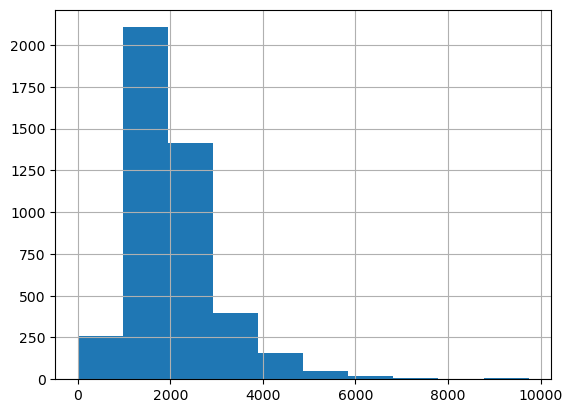

In [217]:
"""There's a rental price outlier. Get rid of it because it may be throwing everything off.
Did some checking and this is in logan square, 68% white, 60th percentile of income"""

bdf1 = bdf[bdf["price1"] < 10000]

bdf1["price1"].hist()

In [220]:
# Rows that have no price should be deleted from dataset, so as not to affect price modeling.
bdf1[bdf1["price1"] == 0]

bdf1 = bdf1[bdf1["price1"] != 0]



Empty GeoDataFrame
Columns: [property_id, listing_id, address, price, price_max, price_min, link, beds, beds_max, beds_min, baths_min, baths_max, sqft_max, sqft_min, property, geometry, STATEFP, COUNTYFP, TRACTCE, BLKGRPCE, GEOID, NAMELSAD, MTFCC, FUNCSTAT, ALAND, AWATER, INTPTLAT, INTPTLON, community, GISJOIN, TRACTA, BLKGRPA, GEO_ID, pop_total, emp_total, perc_white, perc_black, perc_hispanic, perc_asian, perc_native, perc_other, perc_mixed, perc_hsgrad, perc_bachelor, perc_>bachelor, income_medhh, perc_inLaborForce, perc_employed, perc_unemployed, comm_test, pop_density, bg_inc_deciles, bg_geometry, Cnt_Homicide, Cnt_Narcotics, Cnt_Other, Cnt_Sexual Assault, Cnt_Theft, Cnt_Violent Crime, Arrest, crime_tot, arrest_perc, beds1, baths1, sqft1, price1]
Index: []

[0 rows x 66 columns]

looks like only price is missing, but clearly beds has NAs.And baths_min as well It's because it's an object not a float. 
Will use min for both instances

In [148]:
print(bdf.dtypes[bdf.dtypes=="float64"])
print("-------")
print(bdf.dtypes[bdf.dtypes=="int64"])

price                 float64
price_max             float64
price_min             float64
ALAND                 float64
AWATER                float64
pop_total             float64
emp_total             float64
perc_white            float64
perc_black            float64
perc_hispanic         float64
perc_asian            float64
perc_native           float64
perc_other            float64
perc_mixed            float64
perc_hsgrad           float64
perc_bachelor         float64
perc_>bachelor        float64
income_medhh          float64
perc_inLaborForce     float64
perc_employed         float64
perc_unemployed       float64
pop_density           float64
Cnt_Homicide          float64
Cnt_Narcotics         float64
Cnt_Other             float64
Cnt_Sexual Assault    float64
Cnt_Theft             float64
Cnt_Violent Crime     float64
crime_tot             float64
dtype: object
-------
property_id    int64
listing_id     int64
dtype: object


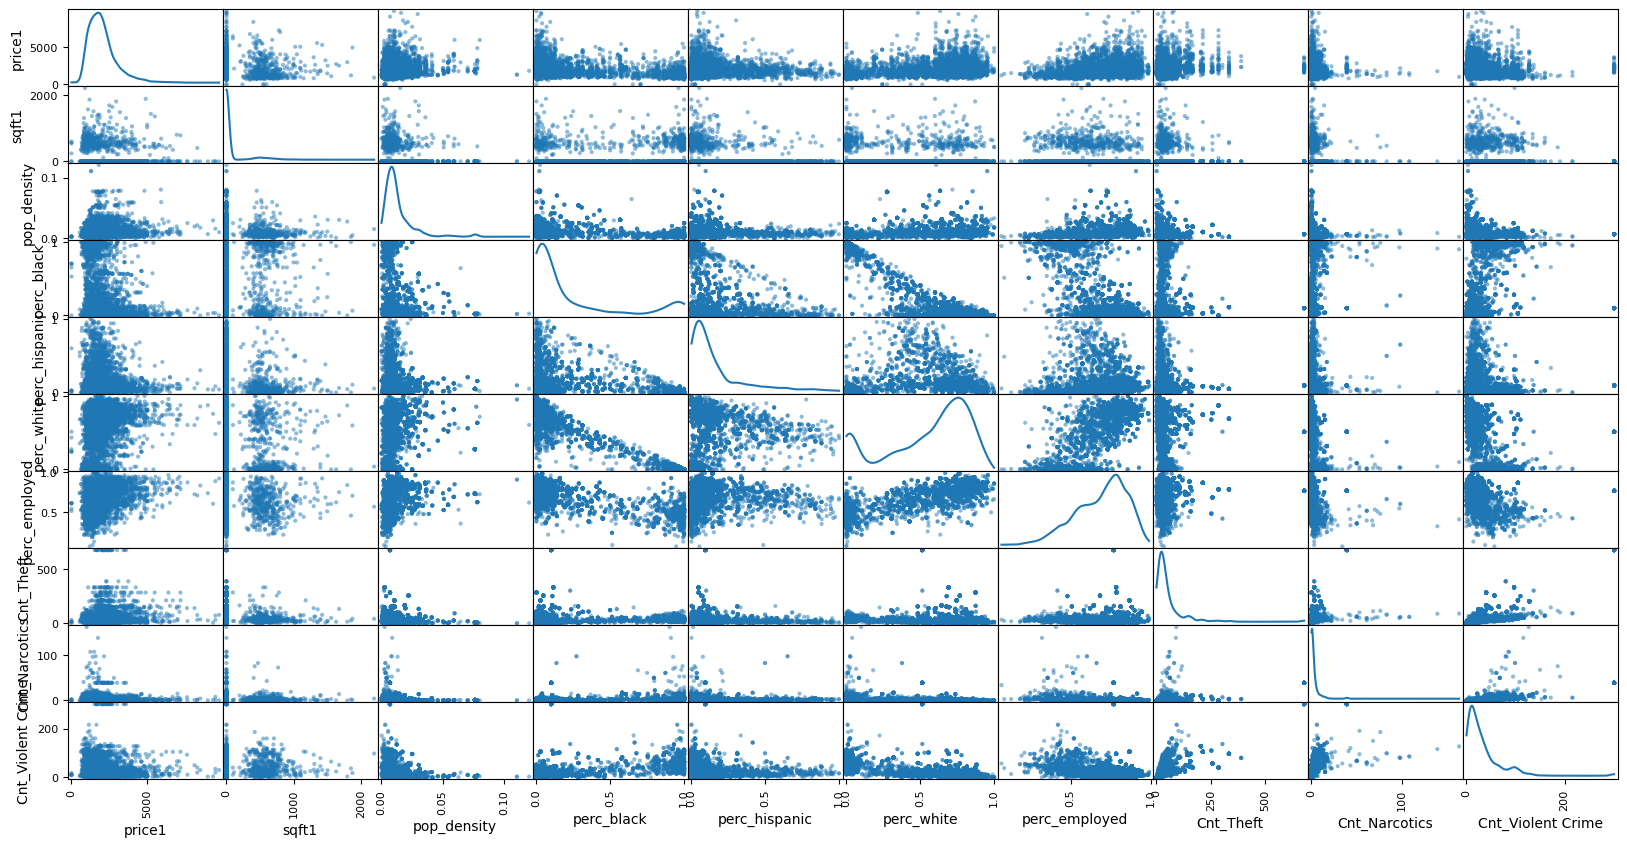

In [222]:
keep_vars = ["price1", "sqft1","beds1", 
             "pop_density",
             "perc_black","perc_hispanic", "perc_white",
             "perc_employed",#"income_medhh", 
             "Cnt_Theft", "Cnt_Narcotics", "Cnt_Violent Crime"]
pd.plotting.scatter_matrix(bdf1[keep_vars], diagonal = 'kde',  figsize=[20,10])
#plt.rcParams['figure.figsize'] = [20, 12]
plt.show()

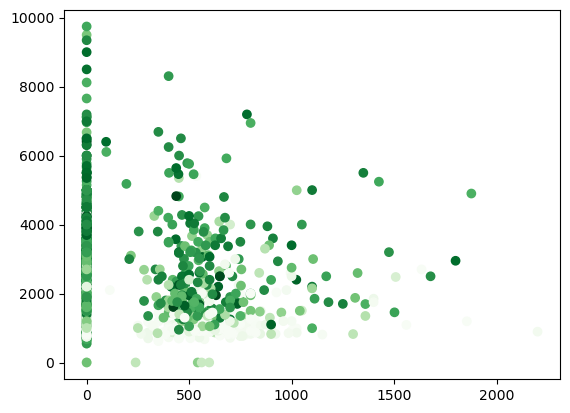

In [223]:
plt.scatter(bdf1["sqft1"],bdf1["price1"], c=bdf1["perc_white"],cmap="Greens")

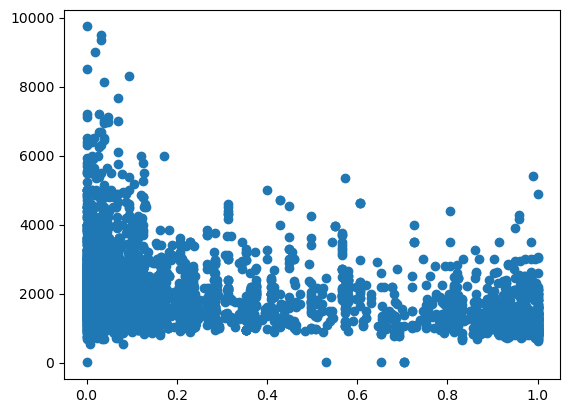

In [224]:
plt.scatter(bdf1["perc_black"],bdf1["price1"])#, c=bdf["perc_white"],cmap="Greens")

<AxesSubplot:>

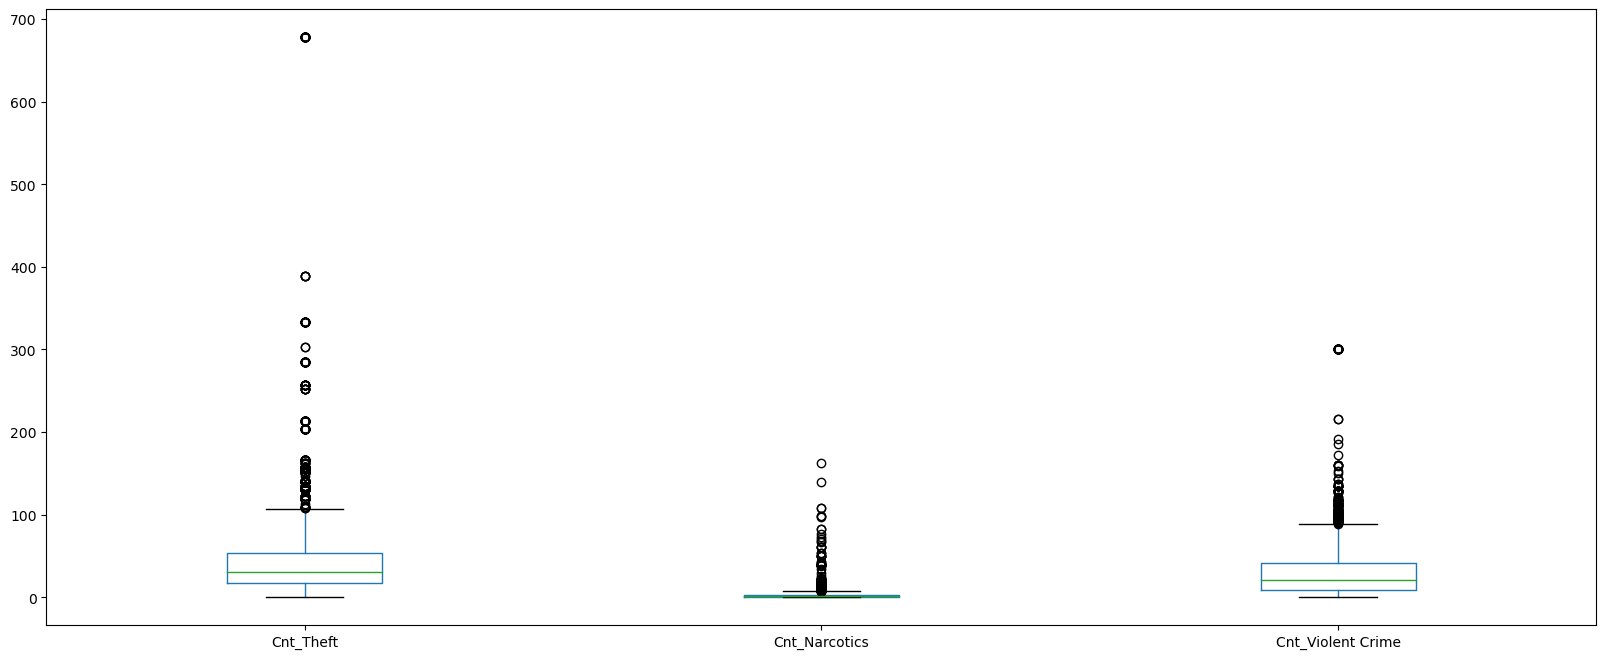

In [225]:
bdf1[["Cnt_Theft", "Cnt_Narcotics", "Cnt_Violent Crime"]].boxplot(figsize=[20,8], grid= False)



In [226]:
# corr plot
bdfcorr = bdf1.drop(columns=["price","baths_min","property_id","listing_id"]).corr()
bdfcorr.style.background_gradient(cmap='coolwarm')

## Making Predictions

Just for an exercise, can we make predictions on prices

We're going to predict price1, which is akin to the minimum price. So we'll use the other "1" variables that were crafted on minimums as well

In [227]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [247]:
c1 = bdf1[["property", "community", "ALAND"]]
c2 = bdf1.iloc[:, 35:]

dat = pd.concat([c1,c2],axis=1)
dat.drop(columns=["bg_geometry","comm_test"], inplace=True)
list(dat.columns)

['property',
 'community',
 'ALAND',
 'perc_white',
 'perc_black',
 'perc_hispanic',
 'perc_asian',
 'perc_native',
 'perc_other',
 'perc_mixed',
 'perc_hsgrad',
 'perc_bachelor',
 'perc_>bachelor',
 'income_medhh',
 'perc_inLaborForce',
 'perc_employed',
 'perc_unemployed',
 'pop_density',
 'bg_inc_deciles',
 'Cnt_Homicide',
 'Cnt_Narcotics',
 'Cnt_Other',
 'Cnt_Sexual Assault',
 'Cnt_Theft',
 'Cnt_Violent Crime',
 'Arrest',
 'crime_tot',
 'arrest_perc',
 'beds1',
 'baths1',
 'sqft1',
 'price1']

In [251]:
dat[dat["beds1"]=="NA"]

property        community     ALAND  perc_white  perc_black  \
1022      condos   NEAR NORTH SIDE   18761.0    0.717795    0.014608   
1069      condos           HERMOSA  261833.0    0.453462    0.000000   
1165      condos    NEAR WEST SIDE  122756.0    0.605323    0.068484   
1169      condos    NEAR WEST SIDE  468467.0    0.874503    0.000000   
1203      condos     HUMBOLDT PARK  248139.0         NaN         NaN   
1205      condos         WEST TOWN  165205.0    0.702840    0.101927   
1388       other   LOWER WEST SIDE  246924.0    0.392535    0.000000   
1983   apartment   NEAR NORTH SIDE   24573.0    0.634096    0.024428   

      perc_hispanic  perc_asian  perc_native  perc_other  perc_mixed  ...  \
1022       0.018592    0.205843          0.0    0.000000    0.061753  ...   
1069       0.645570    0.152643          0.0    0.218913    0.174981  ...   
1165       0.175917    0.169101          0.0    0.052256    0.104836  ...   
1169       0.049587    0.103765          0.0    0.000000    0.021732  ...   
1203            NaN         NaN          NaN         NaN         NaN  ...   
1205       0.284483    0.038540          0.0    0.097870    0.058824  ...   
1388       0.634557    0.099940          0.0    0.476219    0.031306  ...   
1983       0.154886    0.210499          0.0    0.053015    0.077963  ...   

      Cnt_Sexual Assault  Cnt_Theft  Cnt_Violent Crime  Arrest  crime_tot  \
1022                 0.0        2.0                5.0       3       12.0   
1069                 0.0       20.0               24.0       1       76.0   
1165                 0.0       21.0               11.0       9       71.0   
1169                 1.0      285.0               40.0      35      416.0   
1203                 0.0       60.0               86.0     144      353.0   
1205                 0.0       26.0               22.0      10       96.0   
1388                 1.0       27.0               10.0       5       58.0   
1983                 2.0        7.0                8.0       4       35.0   

      arrest_perc  beds1  baths1 sqft1  price1  
1022     0.250000     NA     0.0     0  5900.0  
1069     0.013158     NA     0.0     0  1520.0  
1165     0.126761     NA     0.0     0  1595.0  
1169     0.084135     NA     0.0     0  3995.0  
1203     0.407932     NA     0.0     0  1250.0  
1205     0.104167     NA     0.0     0  2575.0  
1388     0.086207     NA     0.0     0   750.0  
1983     0.114286     NA     0.0     0  3250.0  

[8 rows x 32 columns]

In [249]:
dat.dtypes[dat.dtypes=="object"]
#keep property and bg_inc_deciles. Need to one hot encode

property          object
community         object
bg_inc_deciles    object
beds1             object
dtype: object

In [255]:
# since beds popped up as a object, suspected NAs. Remove these from dataset.
dat[dat["beds1"]=="NA"]
dat = dat[dat["beds1"]!="NA"]

dat["beds1"] = dat["beds1"].astype(int)

In [258]:
# one hot encode data
ohe_dat = pd.get_dummies(dat, columns = ["property","community","bg_inc_deciles"])
ohe_dat
                                      

ALAND  perc_white  perc_black  perc_hispanic  perc_asian  \
0     141579.0    0.684853    0.064609       0.408471    0.068198   
1     122632.0    0.000000    0.993324       0.000000    0.000000   
2     190165.0    0.023697    0.940284       0.026540    0.000000   
3     264477.0    0.104254    0.871560       0.000000    0.000000   
4     191224.0    0.022395    0.977605       0.000000    0.000000   
...        ...         ...         ...            ...         ...   
4422   51202.0    0.704215    0.012355       0.132994    0.109012   
4423  246924.0    0.392535    0.000000       0.634557    0.099940   
4424   51202.0    0.704215    0.012355       0.132994    0.109012   
4425   51202.0    0.704215    0.012355       0.132994    0.109012   
4426  122233.0    0.673314    0.065103       0.139003    0.043402   

      perc_native  perc_other  perc_mixed  perc_hsgrad  perc_bachelor  ...  \
0        0.000000    0.076813    0.105528     0.132265       0.311623  ...   
1        0.000000    0.000000    0.006676     0.244186       0.113953  ...   
2        0.009479    0.026540    0.000000     0.334174       0.040353  ...   
3        0.000000    0.012510    0.011676     0.436312       0.075095  ...   
4        0.000000    0.000000    0.000000     0.436905       0.000000  ...   
...           ...         ...         ...          ...            ...  ...   
4422     0.000000    0.031977    0.142442     0.018709       0.461179  ...   
4423     0.000000    0.476219    0.031306     0.142631       0.124406  ...   
4424     0.000000    0.031977    0.142442     0.018709       0.461179  ...   
4425     0.000000    0.031977    0.142442     0.018709       0.461179  ...   
4426     0.000000    0.198240    0.019941     0.097138       0.472680  ...   

      bg_inc_deciles_Perc_10th  bg_inc_deciles_Perc_20th  \
0                            0                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            1                         0   
...                        ...                       ...   
4422                         0                         0   
4423                         0                         0   
4424                         0                         0   
4425                         0                         0   
4426                         0                         0   

      bg_inc_deciles_Perc_30th  bg_inc_deciles_Perc_40th  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
4422                         0                         0   
4423                         0                         0   
4424                         0                         0   
4425                         0                         0   
4426                         0                         0   

      bg_inc_deciles_Perc_50th  bg_inc_deciles_Perc_60th  \
0                            0                         1   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
4422                         0                         0   
4423                         1                         0   
4424                         0                         0   
4425                         0                         0   
4426                         0                         0   

      bg_inc_deciles_Perc_70th  bg_inc_deciles_Perc_80th  \
0                   

In [270]:
# count missing values per column
missing_col=[ohe_dat[i].isna().sum() for i in ohe_dat.columns]

missing_perc = [i/len(ohe_dat) for i in missing_col]
missing_perc_df = pd.DataFrame({"col_name": ohe_dat.columns, "prop_missing": missing_perc})#.sort_values(by=['prop_missing'], ascending=False)
missing_perc_df


col_name  prop_missing
0                       ALAND      0.000454
1                  perc_white      0.055152
2                  perc_black      0.055152
3               perc_hispanic      0.055152
4                  perc_asian      0.055152
..                        ...           ...
118  bg_inc_deciles_Perc_60th      0.000000
119  bg_inc_deciles_Perc_70th      0.000000
120  bg_inc_deciles_Perc_80th      0.000000
121  bg_inc_deciles_Perc_90th      0.000000
122        bg_inc_deciles_Top      0.000000

[123 rows x 2 columns]

In [275]:
# look again for NA's that may fumble the model
ohe_dat = ohe_dat.dropna()
len(ohe_dat)

4149

In [276]:

X = ohe_dat.drop(columns=["price1"])

y = ohe_dat["price1"]

# splitting X and y into training and testing sets
X_train, X_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.30,
                                       random_state=1)

In [286]:
# create linear regression object
reg = linear_model.LinearRegression()
 
# train the model using the training sets
lr_model = reg.fit(X_train, y_train)
 
# regression coefficients
#print('Coefficients: ', reg.coef_)
 
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(lr_model.score(X_test, y_test)))
 


R-square: 0.26018876973446126


In [294]:
y_pred = lr_model.predict(X_train)
residuals = y_pred - y_train

In [ ]:
def regression_eval_fun(model, y, pred):
    """fitted model, y values, predictions"""
    
    # for ensemble like random forest
    #oob_score = model.oob_score_
    
    r2 = r2_score(y , pred)
    mse = mean_squared_error(y, pred)
    mape = mean_absolute_percentage_error(y, pred)

    print("R-Squared: ", r2)
    print("MSE: ", mse)
    print("MAPE: ", mape)
    
    return

In [336]:
regression_eval_fun(model, y_train, y_pred)

R-Squared:  0.29139411289714545
MSE:  675905.2741664613
MAPE:  0.765049640931726


Text(0.5, 1.0, 'Residuals')

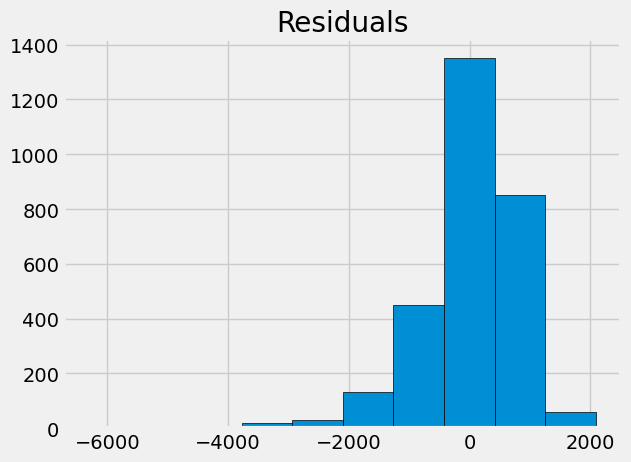

In [300]:
residuals.hist(edgecolor="black")
plt.title ("Linear Regression Residuals")

None-normal histogram/skewed data.

Text(0, 0.5, 'Residuals')

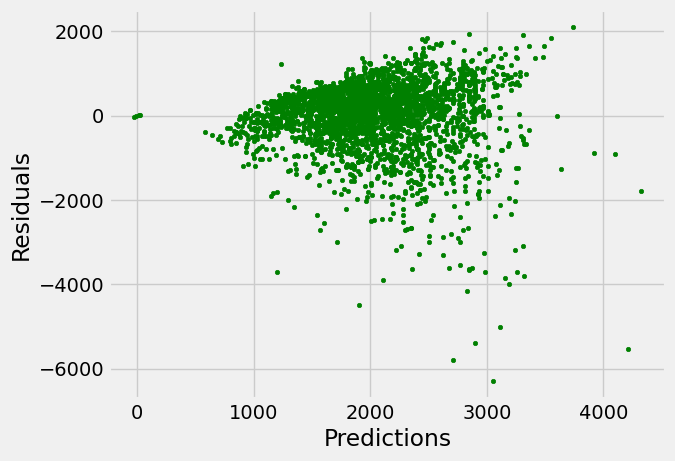

In [303]:
# plot for residual error
 
# setting plot style
plt.style.use('fivethirtyeight')
 
# plotting residual errors in training data
plt.scatter(y_pred,
            residuals,
            color="green", s=10,
            label='Train data')
plt.title("Linear Regression")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
 

The above indicates heteroskedasticity. Unequal error variances.

Text(0, 0.5, 'Actuals')

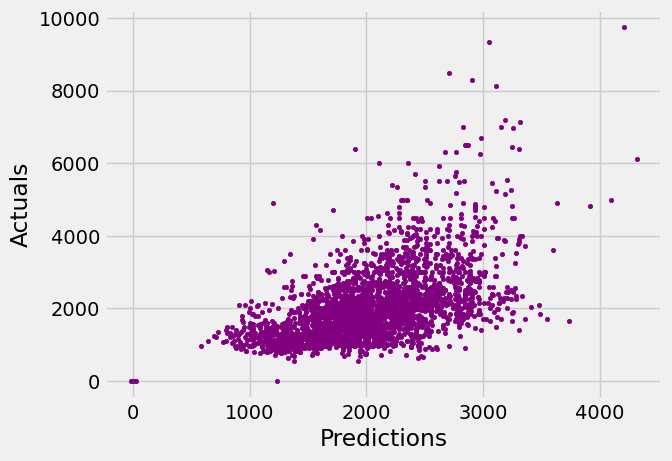

In [304]:
# plotting residual errors in training data
plt.scatter(y_pred,
            y_train,
            color="purple", s=10,
            label='Train data')
plt.xlabel("Predictions")
plt.ylabel("Actuals")

In [284]:
# Use statsmodel to train linear model because it gives more complete summary output
import statsmodels.api as sm

x, y = np.array(X_train), np.array(y_train)
x = sm.add_constant(x)
model = sm.OLS(y, x)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     9.880
Date:                Thu, 21 Dec 2023   Prob (F-statistic):          1.49e-136
Time:                        13:52:06   Log-Likelihood:                -23612.
No. Observations:                2904   AIC:                         4.746e+04
Df Residuals:                    2787   BIC:                         4.816e+04
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1132.4434    259.967      4.356      0.000     622.696    1642.191
x1          1.625e-05   4.58e-05      0.355      0.723   -7.36e-05       0.000
x2           819.0888    230.024      3.561      0.000     368.054    1270.124
x3           491.7652    255.935      1.921      0.055     -10.075     993.606
x4          -298.1612    241.261     -1.236      0.217    -771.229     174.907
x5          -150.7800    282.719     -0.533      0.594    -705.141     403.581
x6         -1968.4610   1082.188     -1.819      0.069   -4090.433     153.511
x7          1074.0174    348.841      3.079      0.002     390.005    1758.030
x8           866.8130    317.636      2.729      0.006     243.987    1489.639
x9          -551.5305    296.495     -1.860      0.063   -1132.903      29.842
x10         -349.7450    253.929     -1.377      0.169    -847.654     148.164
x11          -56.4360    257.453     -0.219      0.827    -561.254     448.382
x12            0.0020      0.002      1.137      0.256      -0.001       0.006
x13         3244.9426   6046.561      0.537      0.592   -8611.249    1.51e+04
x14        -3490.6333   6044.822     -0.577      0.564   -1.53e+04    8362.147
x15        -3929.3944   6078.380     -0.646      0.518   -1.58e+04    7989.187
x16           97.0794   1912.035      0.051      0.960   -3652.068    3846.227
x17          -50.6762     27.637     -1.834      0.067    -104.866       3.514
x18            3.0596      6.779      0.451      0.652     -10.233      16.352
x19            4.1910      5.382      0.779      0.436      -6.362      14.744
x20           42.0581     14.442      2.912      0.004      13.739      70.377
x21            0.4974      5.197      0.096      0.924      -9.693      10.688
x22           -0.1893      5.591     -0.034      0.973     -11.152      10.774
x23           -6.0805      2.830     -2.149      0.032     -11.630      -0.531
x24           -1.0594      5.197     -0.204      0.838     -11.251       9.132
x25         1003.7994    419.201      2.395      0.017     181.824    1825.775
x26           38.5453     13.858      2.782      0.005      11.373      65.718
x27          491.2229     85.856      5.721      0.000     322.875     659.571
x28           -0.1677      0.147     -1.139      0.255      -0.456       0.121
x29         -111.9771    115.944     -0.966      0.334    -339.323     115.369
x30         -367.0892    486.010     -0.755      0.450   -1320.066     585.887
x31          161.3706    122.737      1.315      0.189     -79.294     402.035
x32         -623.5335    770.822     -0.809      0.419   -2134.974     887.907
x33          151.1928    317.139      0.477      0.634    -470.658     773.044
x34         1157.9662    364.742      3.175      0.002     442.775    1873.157
x35          633.1747    247.701      2.556      0.011     147.480    1118.870
x3

In [389]:
#z=results.summary()
#pd.DataFrame(z.tables[1]).rename(columns=#.iloc[:,3:]#[z.tables[1]["P>|t|"] < .05]

The linear regression model performed very poorly. Some things that could explore to improve would be:
* feature selection...I know some of these variables are correlated
* transformations
* normalization
However, since the performance was so poor, I'm not going to bother exploring these right now and will try another model.

* how to assess/evaluate this model
 * Check R^2
 * Check the accuracy (I like MAPE)
 * Check some model assumptions: equal variances, normality, linearity, colinearity
* how to code this model from scratch
* cross validation
* try other models? Others from scratch
* think about price elasticity...is this something we can play around with based on the data we have
----
organize this work and add more comments
put the scraper file in this folder
put the work on github

## Random Forest

In [326]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [339]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [388]:
# Making predictions on the same data or new data
predictions = rf.predict(X_train)

print("random forest")
regression_eval_fun(rf, y_train, predictions)


random forest
R-Squared:  0.8408814140042924
MSE:  151775.61102706112
MAPE:  1.1443188653061347


In [398]:
rf_residuals = predictions - y_train

resrange = rf_residuals.max() - rf_residuals.min()


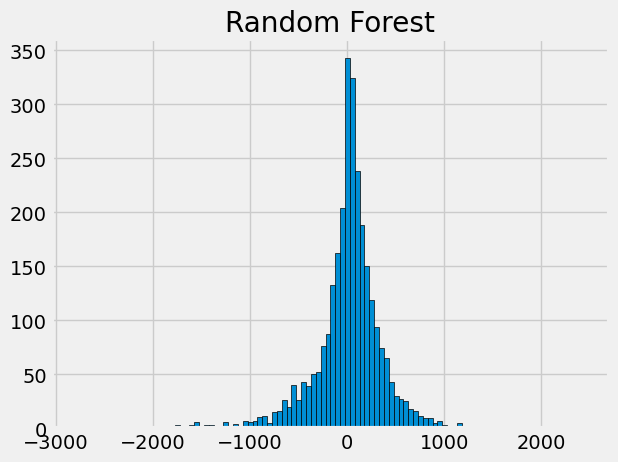

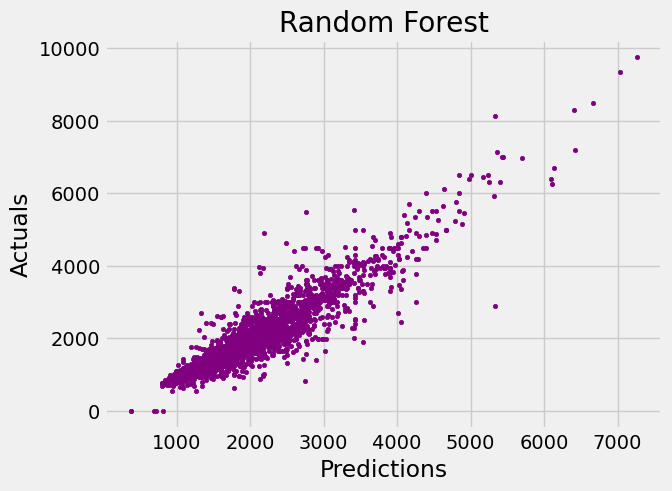

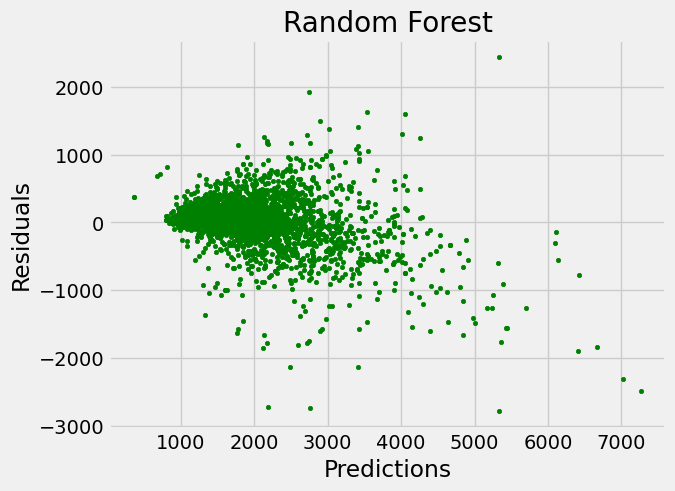

In [397]:
rf_residuals.hist(edgecolor="black", bins=round(resrange/50))
plt.title("Random Forest")
plt.show()

plt.scatter(predictions, y_train,
            color="purple", s=10,
            label='Train data')
plt.title("Random Forest")
plt.xlabel("Predictions")
plt.ylabel("Actuals")

plt.show()

# plotting residual errors in training data
plt.scatter(predictions,
            rf_residuals,
            color="green", s=10,
            label='Train data')
plt.title("Random Forest")
plt.xlabel("Predictions")
plt.ylabel("Residuals")

plt.show()

plt.style.use('default')

In [381]:
# put error into buckets to see for each bucket, what percentage of errors landed there.
# This just gives a more real-world idea of performance

err_buckets = np.where(residuals.abs() < 100, "Err<100",
         np.where(residuals.abs() < 200, "Err100_200",
                 np.where(residuals.abs() < 500, "Err200_500",
                         np.where(residuals.abs() < 1000, "Err500_1000",
                                 "Err>1000"))))

err_buckets = pd.Series(err_buckets)
err_buckets.value_counts()

Err200_500     904
Err500_1000    883
Err>1000       446
Err100_200     341
Err<100        330
dtype: int64

In [386]:
print("Within $200 off: ", (err_buckets.value_counts()[4] + err_buckets.value_counts()[3])/len(err_buckets))
print("Within $500 off: ", (err_buckets.value_counts()[4] + err_buckets.value_counts()[3] + err_buckets.value_counts()[0])/len(err_buckets))

# So only about 55% of listings got a prediction within $500 of actual price

Within $200 off:  0.23106060606060605
Within $500 off:  0.5423553719008265


In [387]:
print("linear regression")
regression_eval_fun(lr_model, y_train, y_pred)


linear regression
R-Squared:  0.29139411289714545
MSE:  675905.2741664613
MAPE:  0.765049640931726


In [361]:
#Feature Importance
# impurity importance...mean decrease impurity

z = pd.DataFrame(X.columns, rf.feature_importances_ ).reset_index()\
.rename(columns={"index":"importance", "0":"feature"}) \
.sort_values("importance", ascending=False)

z.head(20)

# note: look into importance using SHAP values

importance                     0
11    0.187609          income_medhh
25    0.097103                 beds1
27    0.052008                 sqft1
10    0.042228        perc_>bachelor
4     0.040848            perc_asian
9     0.029763         perc_bachelor
24    0.029056           arrest_perc
2     0.028511            perc_black
26    0.026712                baths1
0     0.025993                 ALAND
1     0.025581            perc_white
15    0.024817           pop_density
14    0.024549       perc_unemployed
18    0.024127             Cnt_Other
8     0.023133           perc_hsgrad
3     0.022750         perc_hispanic
28    0.021663  property_ apartment 
20    0.021656             Cnt_Theft
7     0.021385            perc_mixed
12    0.018555     perc_inLaborForce